<a href="https://colab.research.google.com/github/ealeongomez/GuajiraSustainableWindBot/blob/develop/test/smoke/RNN_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Preliminares**

## **Packages**

In [1]:
!git clone https://github.com/ealeongomez/GuajiraSustainableWindBot.git

Cloning into 'GuajiraSustainableWindBot'...
remote: Enumerating objects: 80, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 80 (delta 22), reused 68 (delta 13), pack-reused 0 (from 0)
Receiving objects: 100% (80/80), 6.09 MiB | 10.92 MiB/s, done.
Resolving deltas: 100% (22/22), done.


In [2]:
%cd GuajiraSustainableWindBot
!git fetch origin
!git checkout develop

/content/GuajiraSustainableWindBot
Branch 'develop' set up to track remote branch 'develop' from 'origin'.
Switched to a new branch 'develop'


In [3]:
!pip install tabulate

In [4]:
# Basic packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import seaborn as sns
import os, pickle, re, pickle
from zipfile import ZipFile
from warnings import filterwarnings
from tabulate import tabulate

# Machine learning packages
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from tensorflow import keras

# Performance metrics
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, r2_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit

filterwarnings('ignore')

## Variables

In [10]:
window = 50                # Size of array
predictionHorizonMax = 12  # Maximum prediction horizon
neurons = 16               # Number of neurons in LSTM
epochs = 50                # Number of epochs
batch_size = 256           # Batch size

## **Functions**

In [6]:
def SerieMatriz(timeSerie, predictionHorizonMax, window):
  timeSerie = np.squeeze(timeSerie)

  X = np.zeros([len(timeSerie)-predictionHorizonMax-window+1, window])
  y = np.zeros([len(timeSerie)-predictionHorizonMax-window+1, predictionHorizonMax])
  for i in range(X.shape[0]):
      X[i,:] = timeSerie[i:i+window]
      y[i,:] = timeSerie[i+window: i+window+predictionHorizonMax]

  return X, np.squeeze(y)

# **Read datasets**

================================================ la_jagua_del_pilar


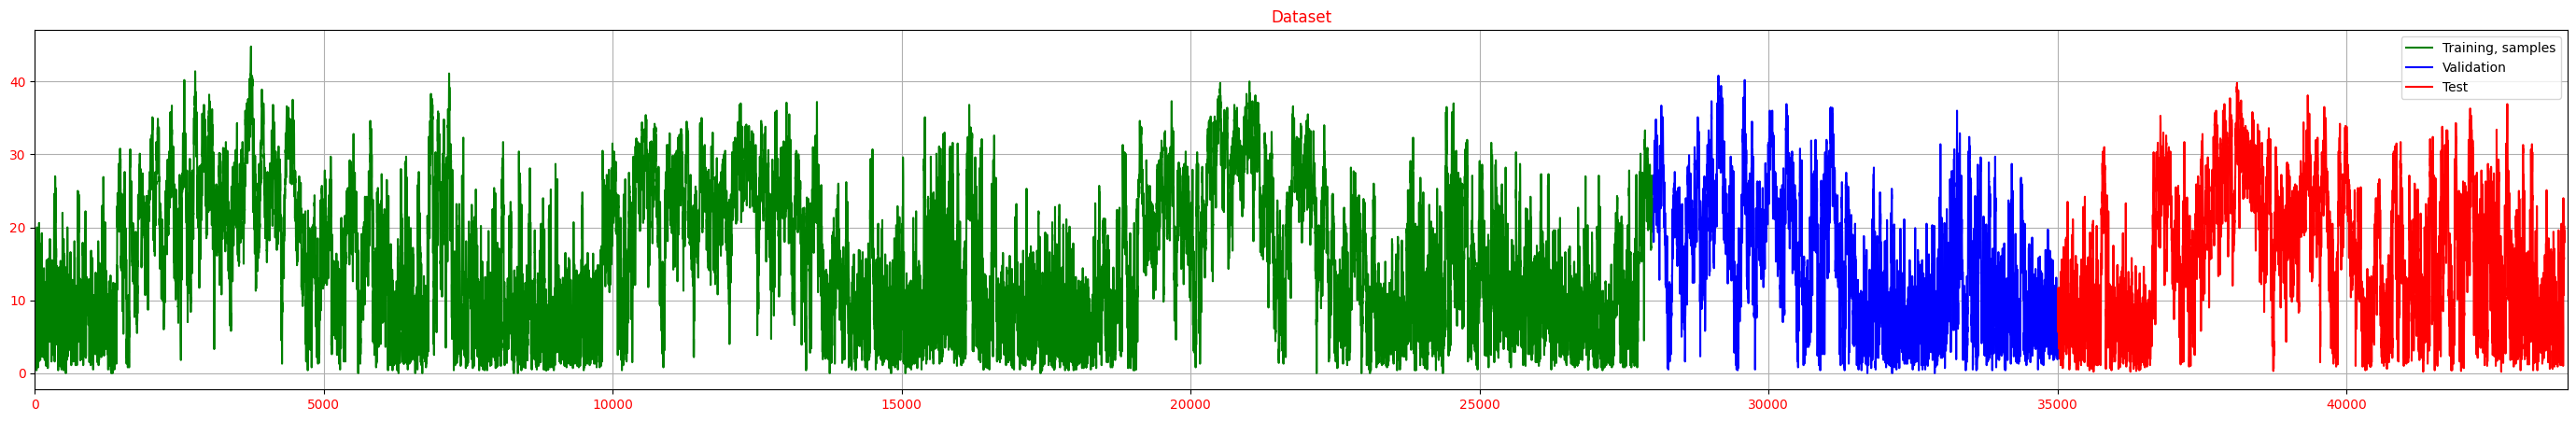

================================================ distraccion


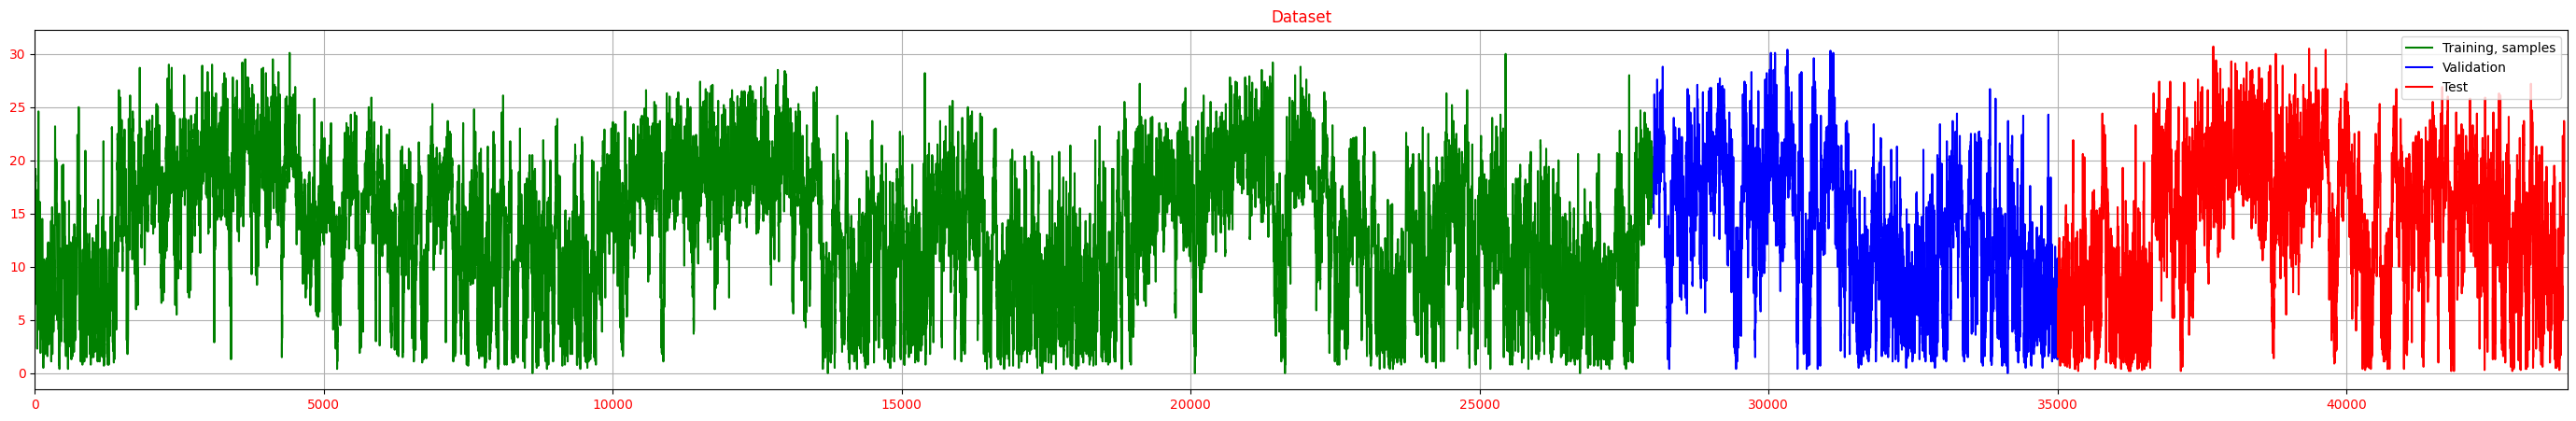

================================================ uribia


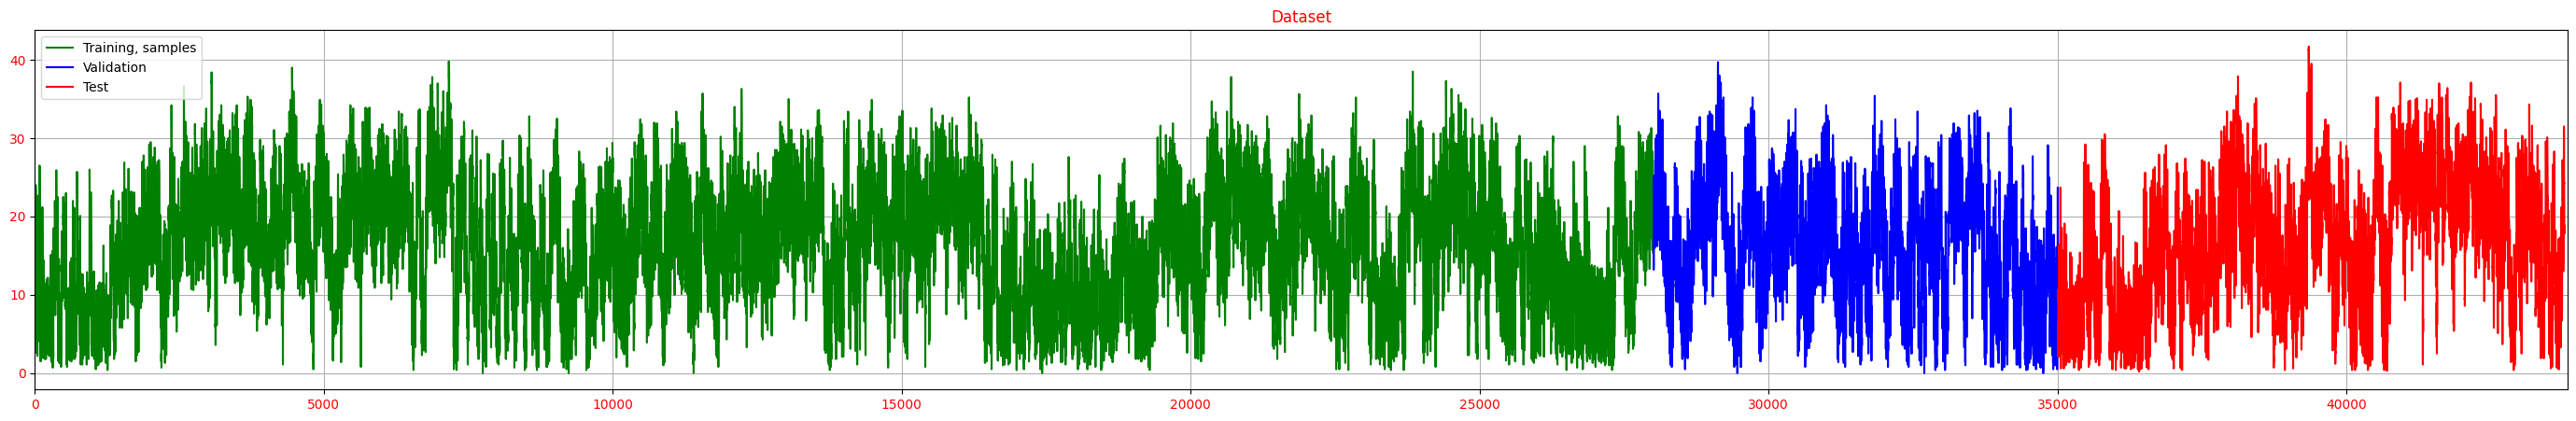

================================================ riohacha


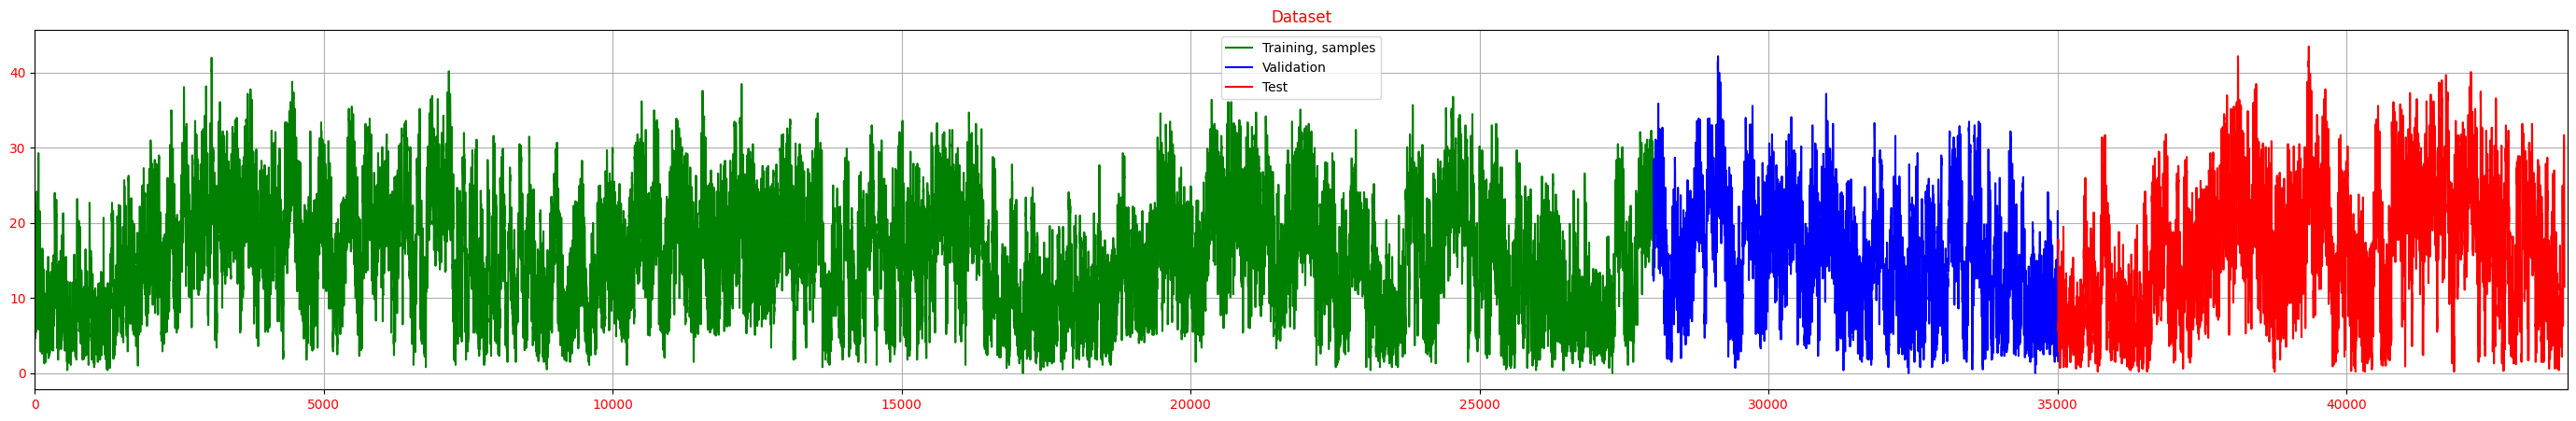

================================================ hatonuevo


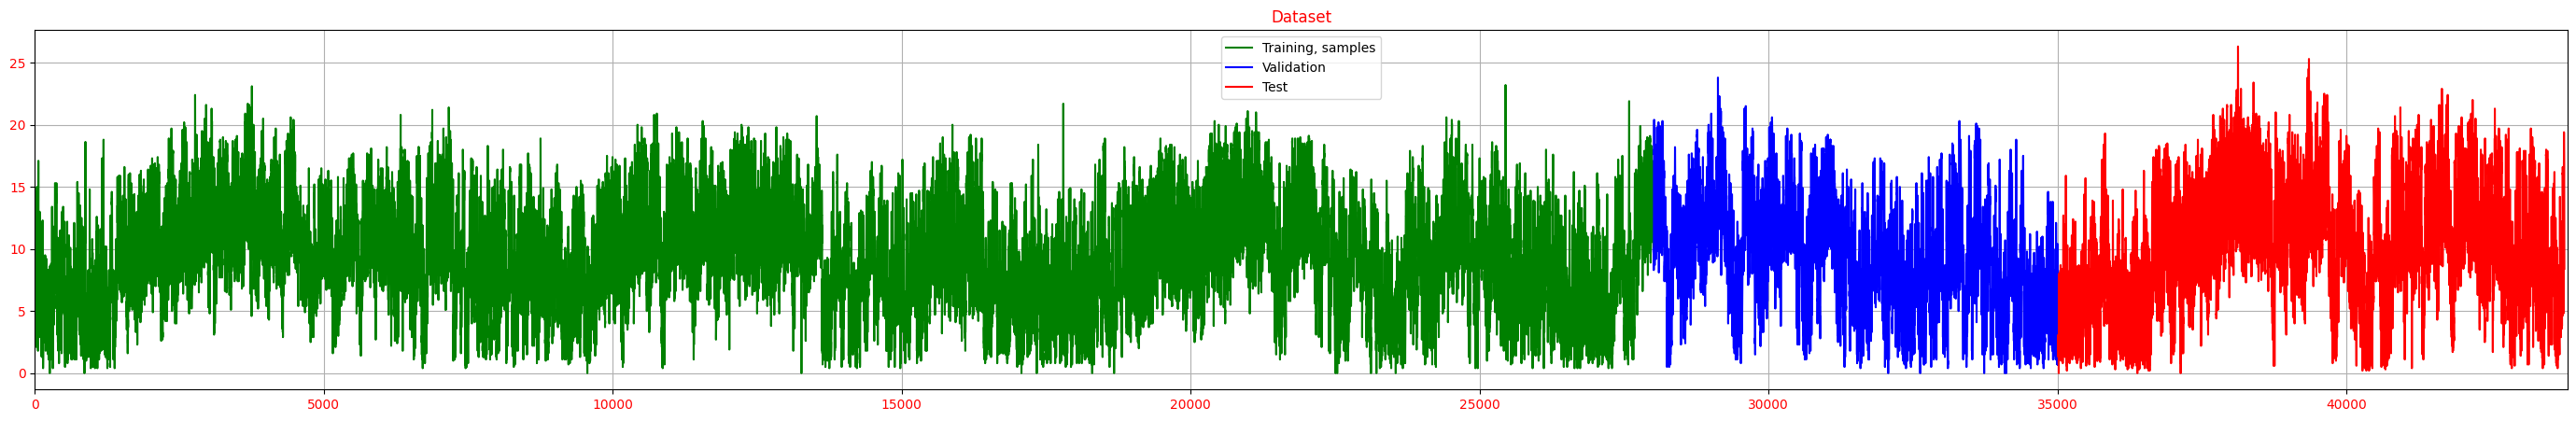

================================================ el_molino


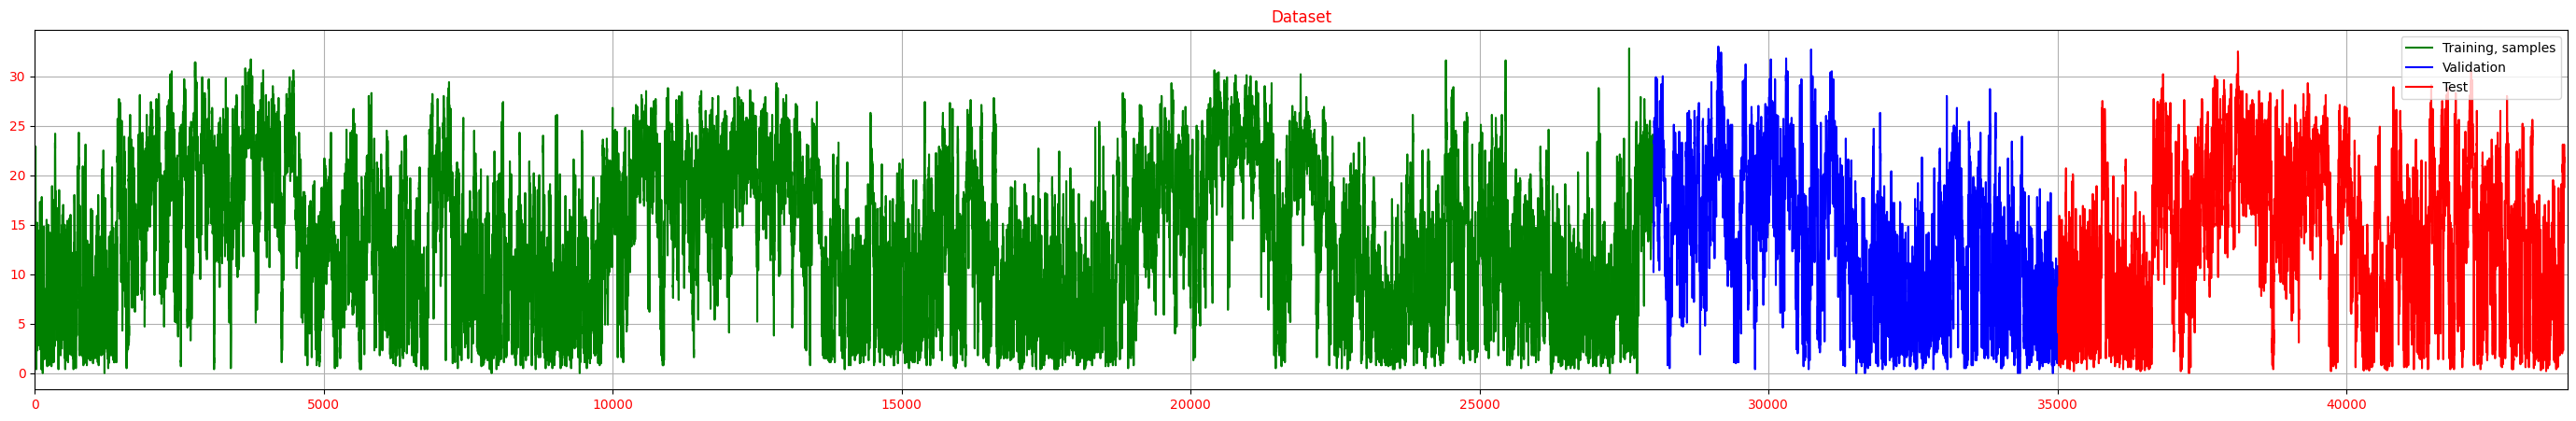

================================================ mingueo


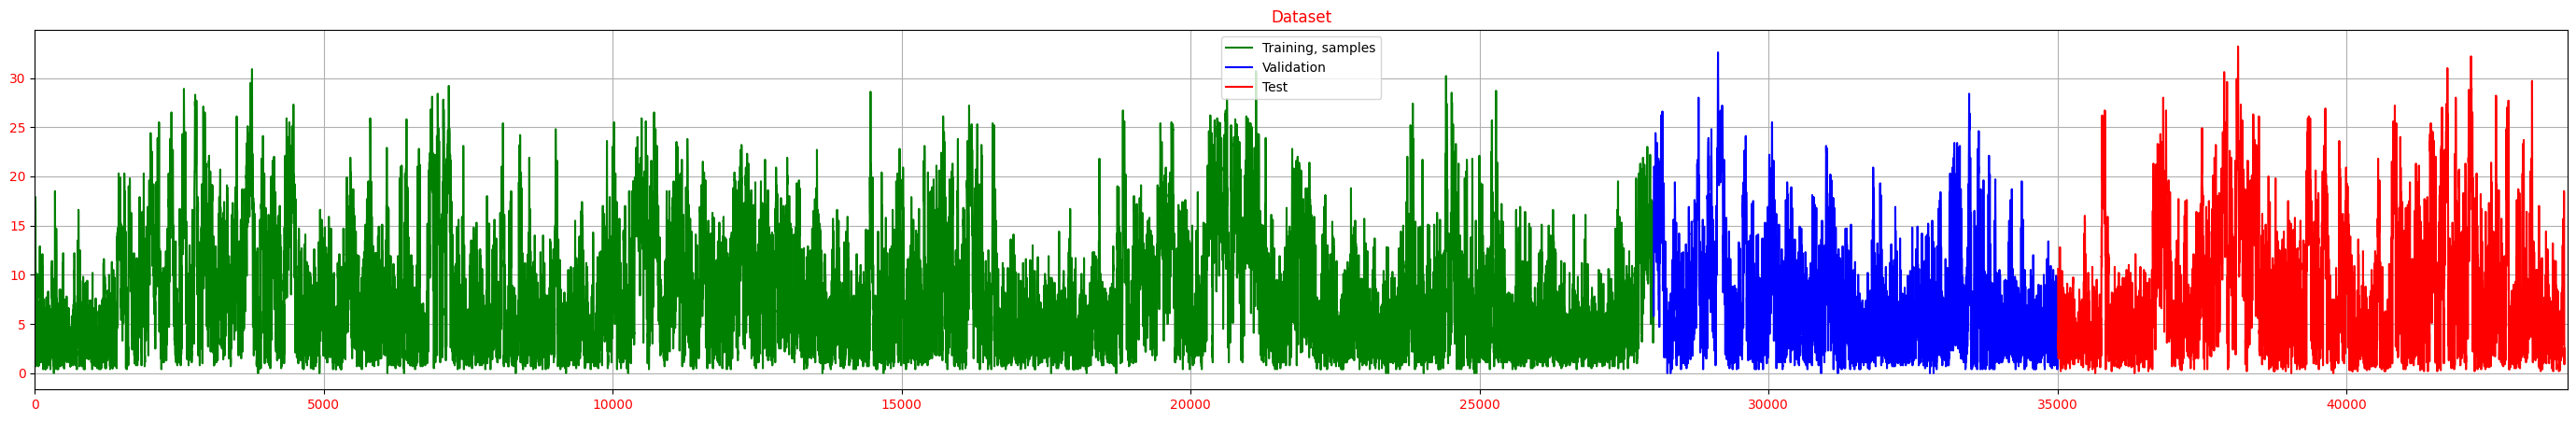

================================================ barrancas


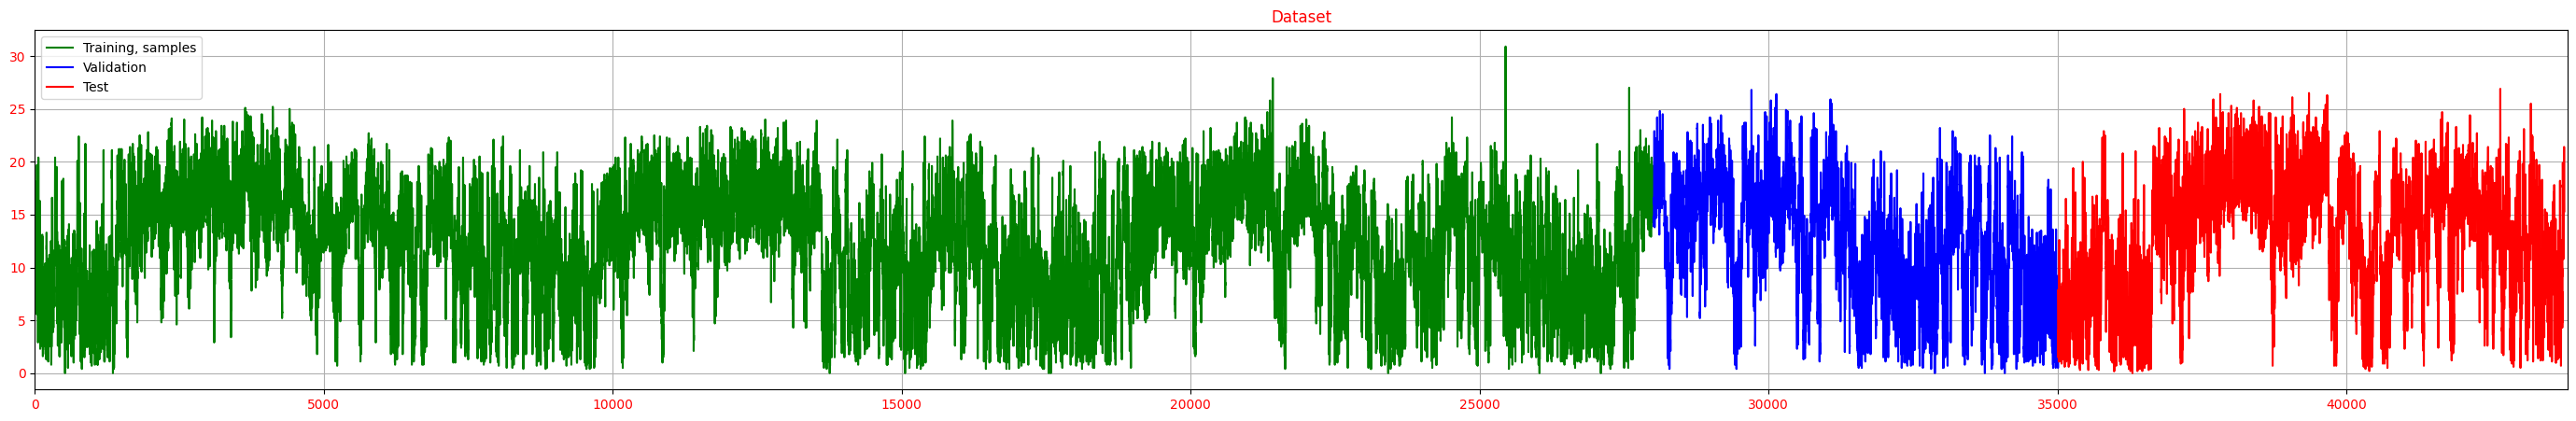

================================================ fonseca


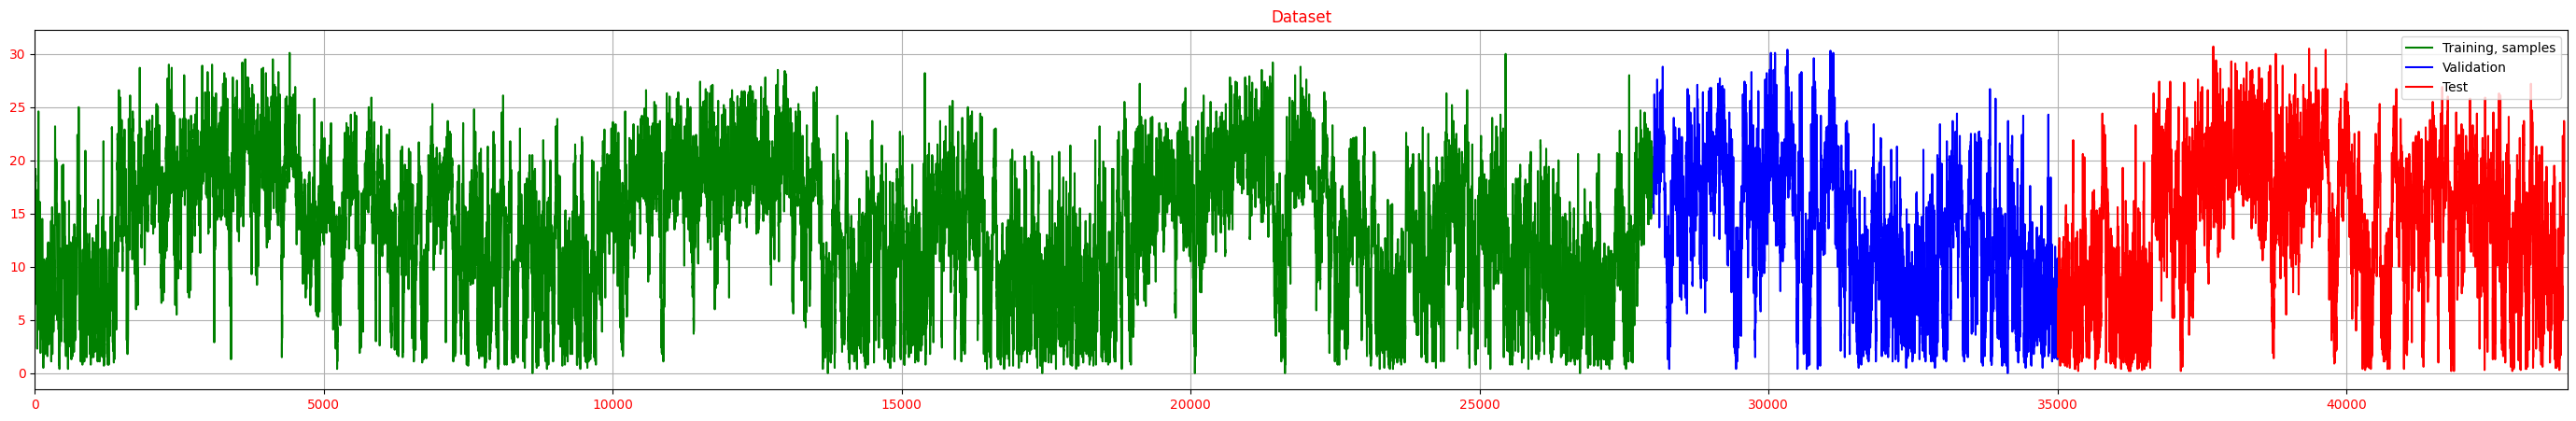

================================================ manaure


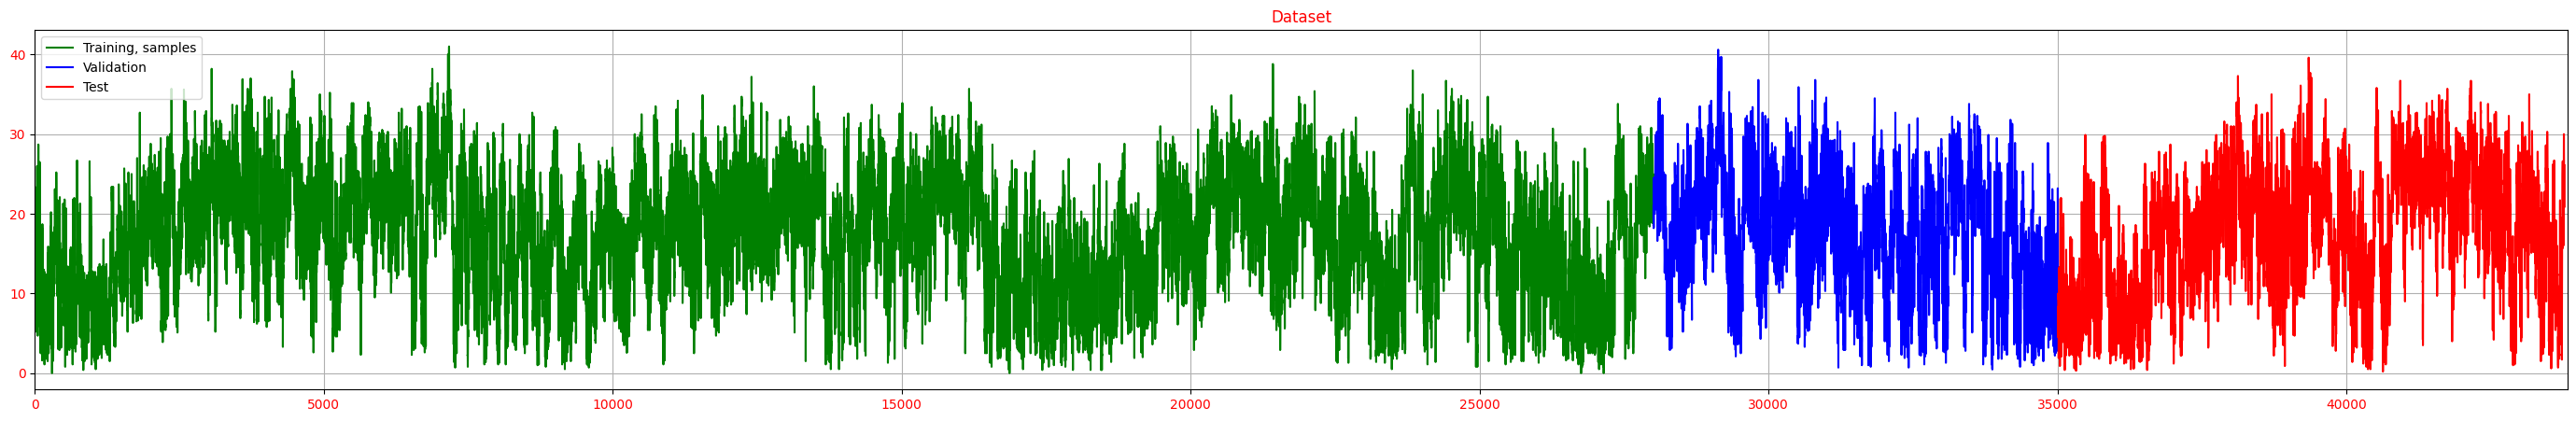

================================================ maicao


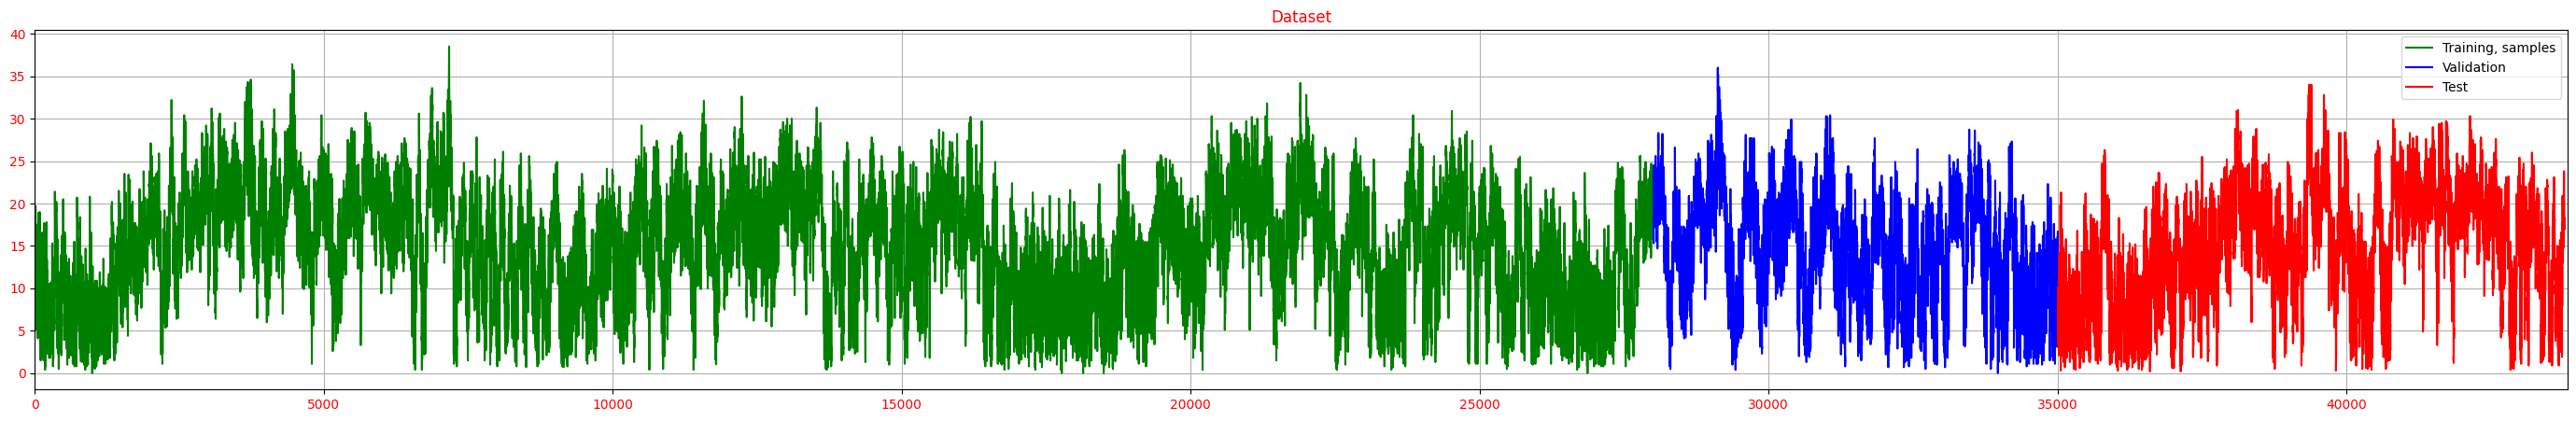

================================================ san_juan_del_cesar


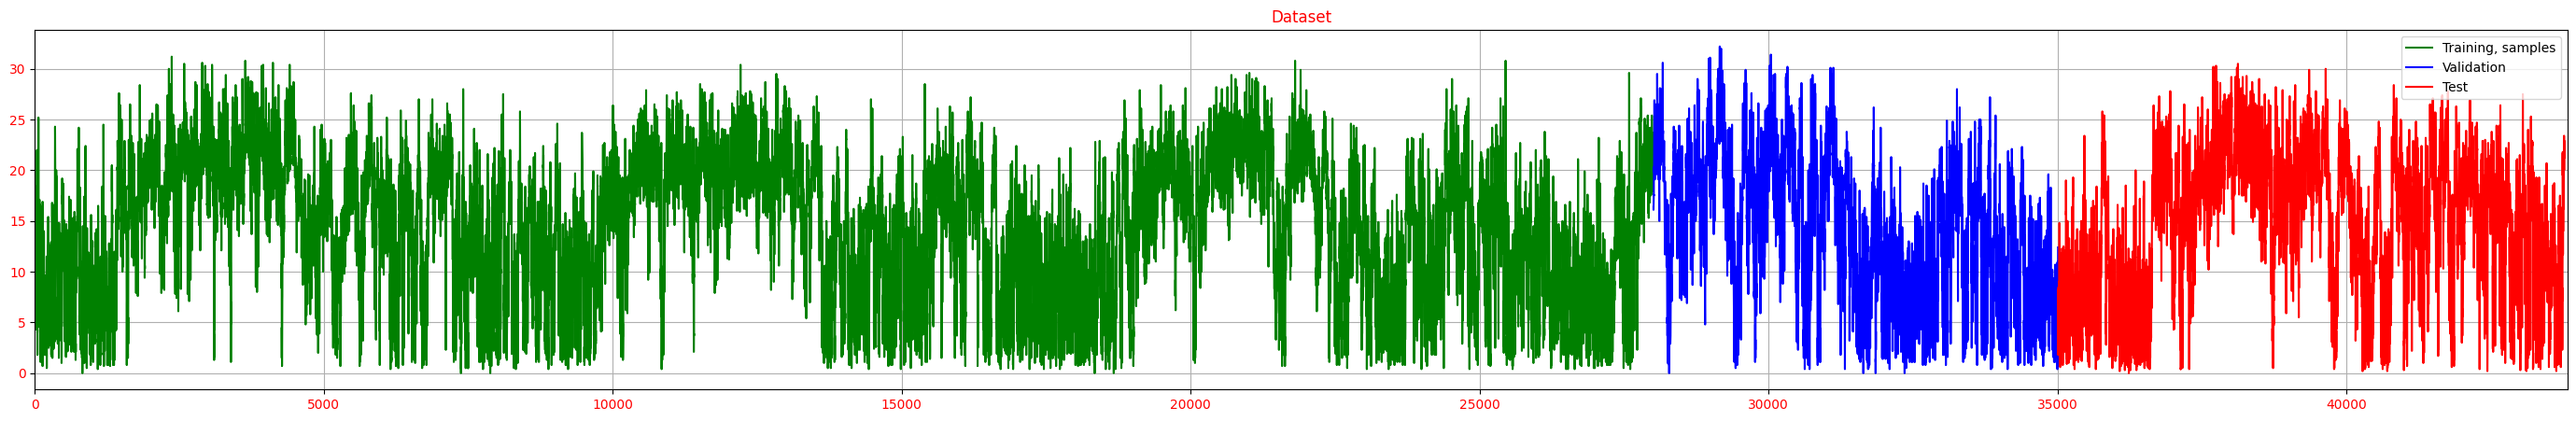

================================================ albania


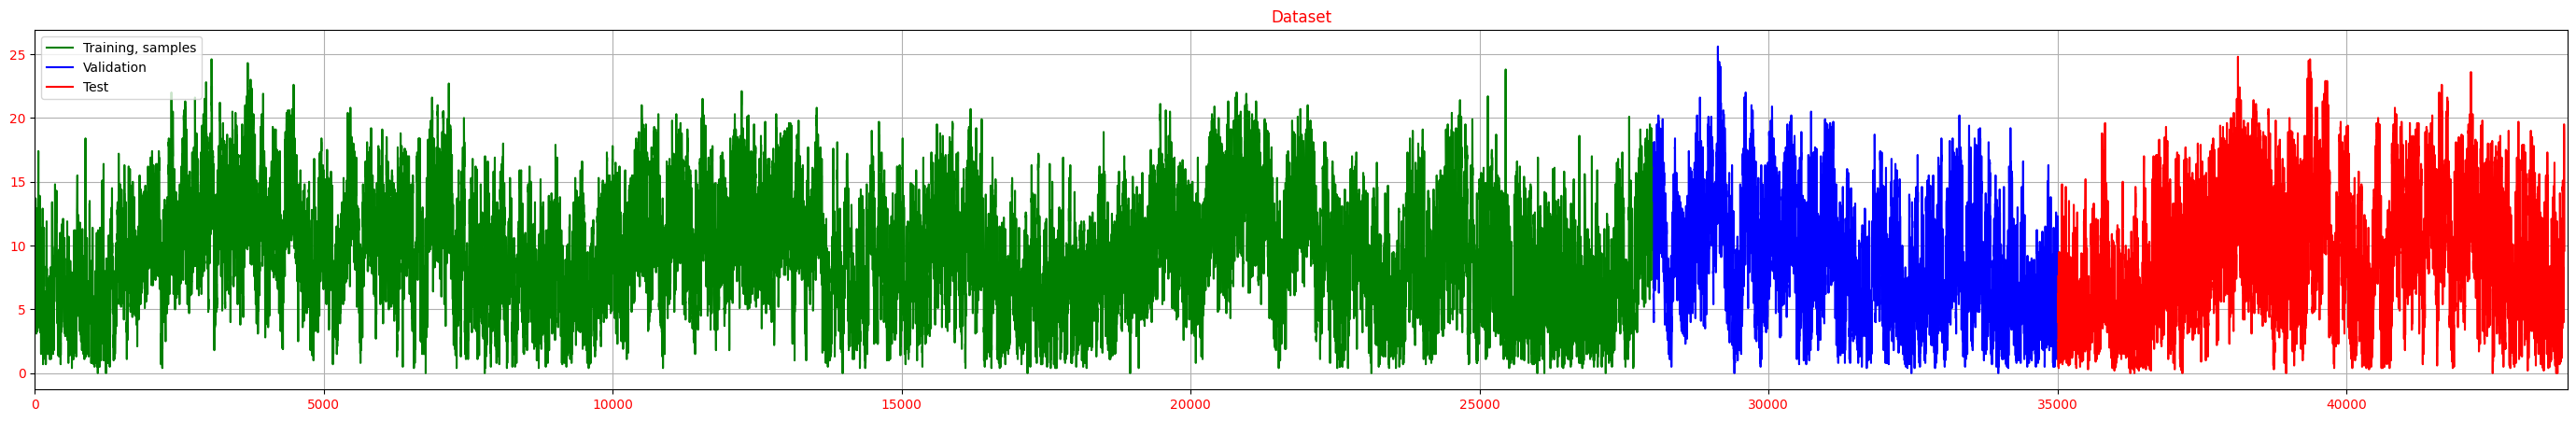

In [7]:
path = '/content/GuajiraSustainableWindBot'
datasets = os.listdir(f"{path}/data/raw/")

data = {}
for csv_file in datasets:

    name = csv_file.split('.')[0]
    name = re.sub(r'open_meteo_', '', name)

    print("======"*8, name)


    # Read dataset
    df = pd.read_csv(path + '/data/raw/' + csv_file)

    timeSerie = df['wind_speed_10m']
    time = np.arange(0, len(timeSerie),1)

    # Fill missing values
    valueMax = timeSerie.max()
    mean_value = timeSerie.mean()
    timeSerie_filled = timeSerie.fillna(mean_value)

    timeSerieNormalized = timeSerie_filled / valueMax

    # Create time series matrix
    X, y = SerieMatriz(timeSerieNormalized, predictionHorizonMax, window)

    X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_valid, y_train, y_valid = train_test_split(X_, y_, test_size=0.2, random_state=42)

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    data[name] = {}
    data[name]['X_train'] = X_train
    data[name]['X_valid'] = X_valid
    data[name]['X_test'] = X_test
    data[name]['y_train'] = y_train*valueMax
    data[name]['y_valid'] = y_valid*valueMax
    data[name]['y_test'] = y_test*valueMax
    data[name]['timeSerie'] = timeSerie_filled
    data[name]['mean_value'] = mean_value
    data[name]['valueMax'] = valueMax

    # Plot dataset
    plt.figure(figsize=(35,5))
    plt.plot(time[0:X_train.shape[0]], timeSerie[0:X_train.shape[0]], 'g', label= 'Training, samples')
    plt.plot(time[X_train.shape[0]:X_train.shape[0]+X_valid.shape[0]], timeSerie[X_train.shape[0]:X_train.shape[0]+X_valid.shape[0]], 'b', label= 'Validation')
    plt.plot(time[X_train.shape[0]+X_valid.shape[0]:], timeSerie[X_train.shape[0]+X_valid.shape[0]:], 'r', label= 'Test')
    plt.title('Dataset', c='r')
    plt.xticks(c='r')
    plt.yticks(c='r')
    plt.xlim(0,timeSerie.shape[0])
    plt.legend()
    plt.grid(True)
    plt.show()


    os.makedirs(f'{path}/models/LSTM/{name}', exist_ok=True)

    with open(f'{path}/models/LSTM/{name}_dataset.pkl', 'wb') as f:
        pickle.dump(data, f)

# **Train model**

In [8]:
def LSTM_model(X_train, y_train, X_valid, y_valid, X_test, y_test):

    model_LSTM = keras.models.Sequential([
    keras.layers.LSTM(neurons, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(neurons, return_sequences=True),
    keras.layers.LSTM(neurons),
    keras.layers.Dense(predictionHorizonMax)
    ])

    return model_LSTM


================================================ la_jagua_del_pilar
Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 307.4140 - mae: 14.9245 - mape: 308989.4062 - mse: 307.4140 - val_loss: 244.0018 - val_mae: 12.7704 - val_mape: 1444110.3750 - val_mse: 244.0018
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 226.8093 - mae: 12.1447 - mape: 1691448.0000 - mse: 226.8093 - val_loss: 194.6071 - val_mae: 11.0663 - val_mape: 2407484.2500 - val_mse: 194.6071
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 181.6264 - mae: 10.6026 - mape: 2714433.0000 - mse: 181.6264 - val_loss: 161.1586 - val_mae: 9.9570 - val_mape: 3193012.0000 - val_mse: 161.1586
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 152.0708 - mae: 9.6430 - mape: 3333408.5000 - mse: 152.0708 - val_loss: 136.9172 - val_mae: 9.1964 - val_mape: 3877589.2500 - val_mse: 136.9172
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 131.4819 - mae: 9.0127 - mape: 4199534.5000 - m

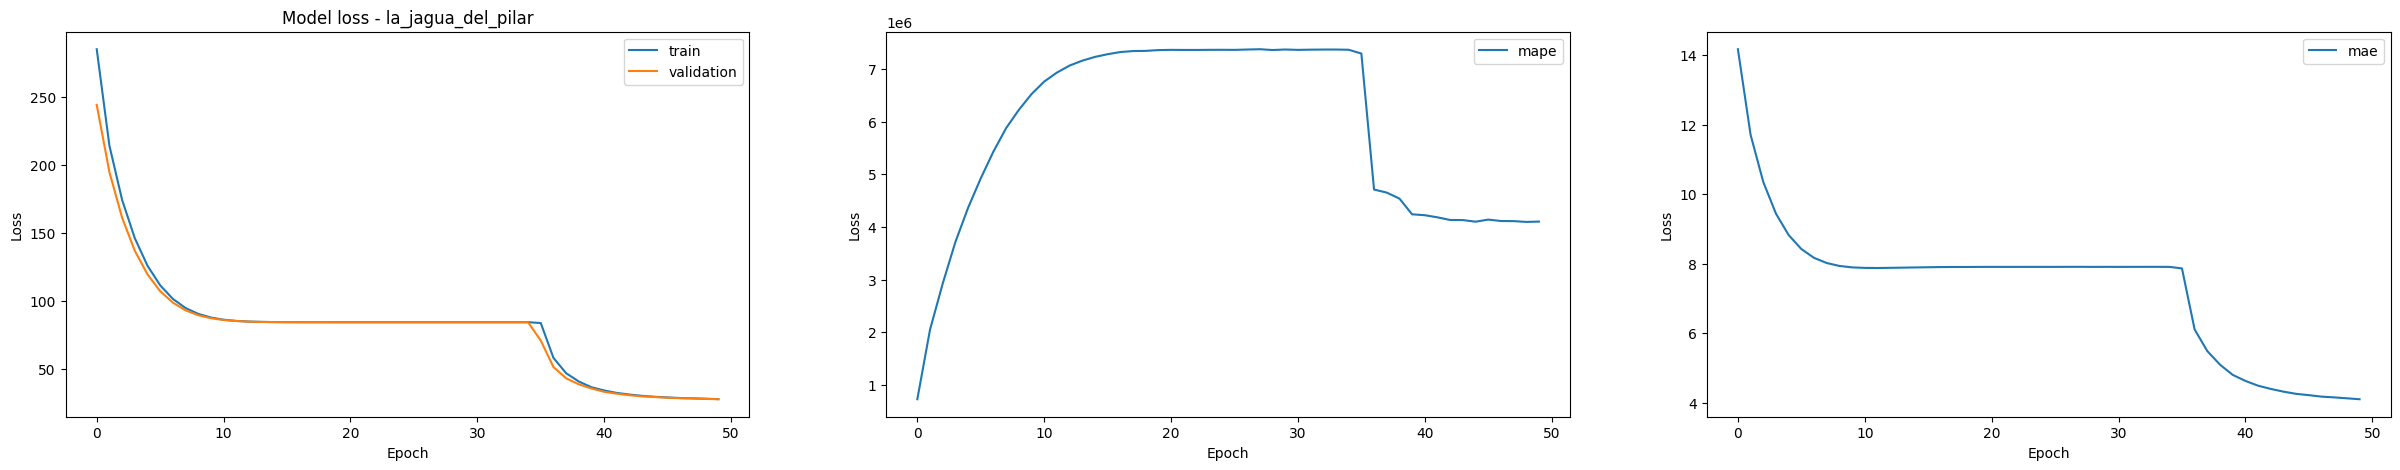

================================================ distraccion
Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 202.1593 - mae: 12.7033 - mape: 106227.8750 - mse: 202.1593 - val_loss: 145.2228 - val_mae: 10.3674 - val_mape: 494011.2500 - val_mse: 145.2228
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 131.9539 - mae: 9.7695 - mape: 591969.8125 - mse: 131.9539 - val_loss: 107.0803 - val_mae: 8.7088 - val_mape: 815941.8750 - val_mse: 107.0803
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 98.3409 - mae: 8.2879 - mape: 1069343.2500 - mse: 98.3409 - val_loss: 82.9247 - val_mae: 7.6261 - val_mape: 1071912.1250 - val_mse: 82.9247
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 77.2860 - mae: 7.3262 - mape: 968268.6250 - mse: 77.2860 - val_loss: 66.7989 - val_mae: 6.8692 - val_mape: 1287279.7500 - val_mse: 66.7989
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 63.5933 - mae: 6.6787 - mape: 979071.6875 - mse: 63.5933 - val_loss: 

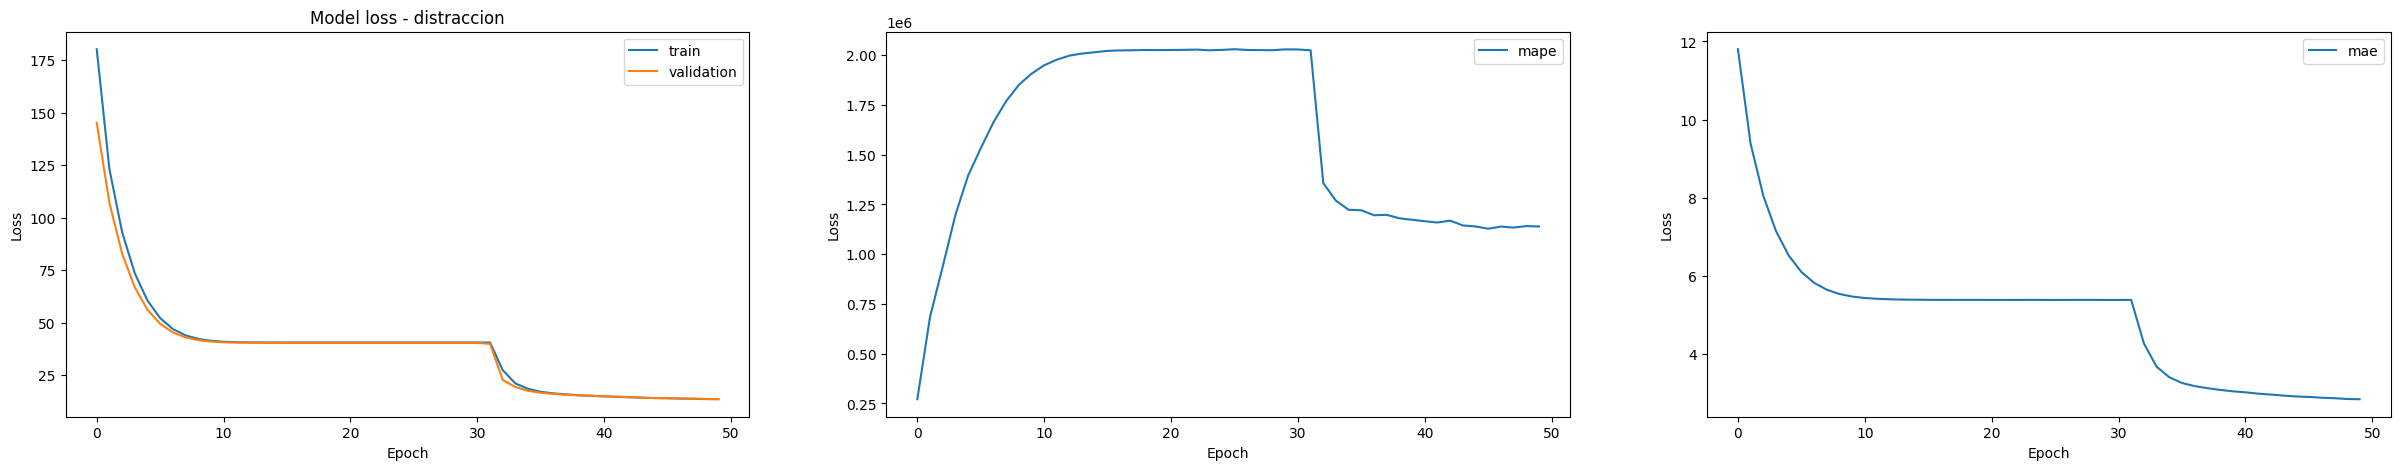

================================================ uribia
Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 298.0537 - mae: 15.3354 - mape: 110647.7109 - mse: 298.0537 - val_loss: 231.9730 - val_mae: 13.0578 - val_mape: 707900.0625 - val_mse: 231.9730
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 218.9742 - mae: 12.5861 - mape: 522344.9688 - mse: 218.9742 - val_loss: 182.5845 - val_mae: 11.2460 - val_mape: 1249350.8750 - val_mse: 182.5845
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 172.1740 - mae: 10.8643 - mape: 551516.9375 - mse: 172.1740 - val_loss: 147.8327 - val_mae: 9.9403 - val_mape: 1704158.0000 - val_mse: 147.8327
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 140.4137 - mae: 9.6498 - mape: 751234.2500 - mse: 140.4137 - val_loss: 122.1246 - val_mae: 8.9636 - val_mape: 2106320.7500 - val_mse: 122.1246
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 116.4790 - mae: 8.7740 - mape: 932653.2500 - mse: 116.4790 - va

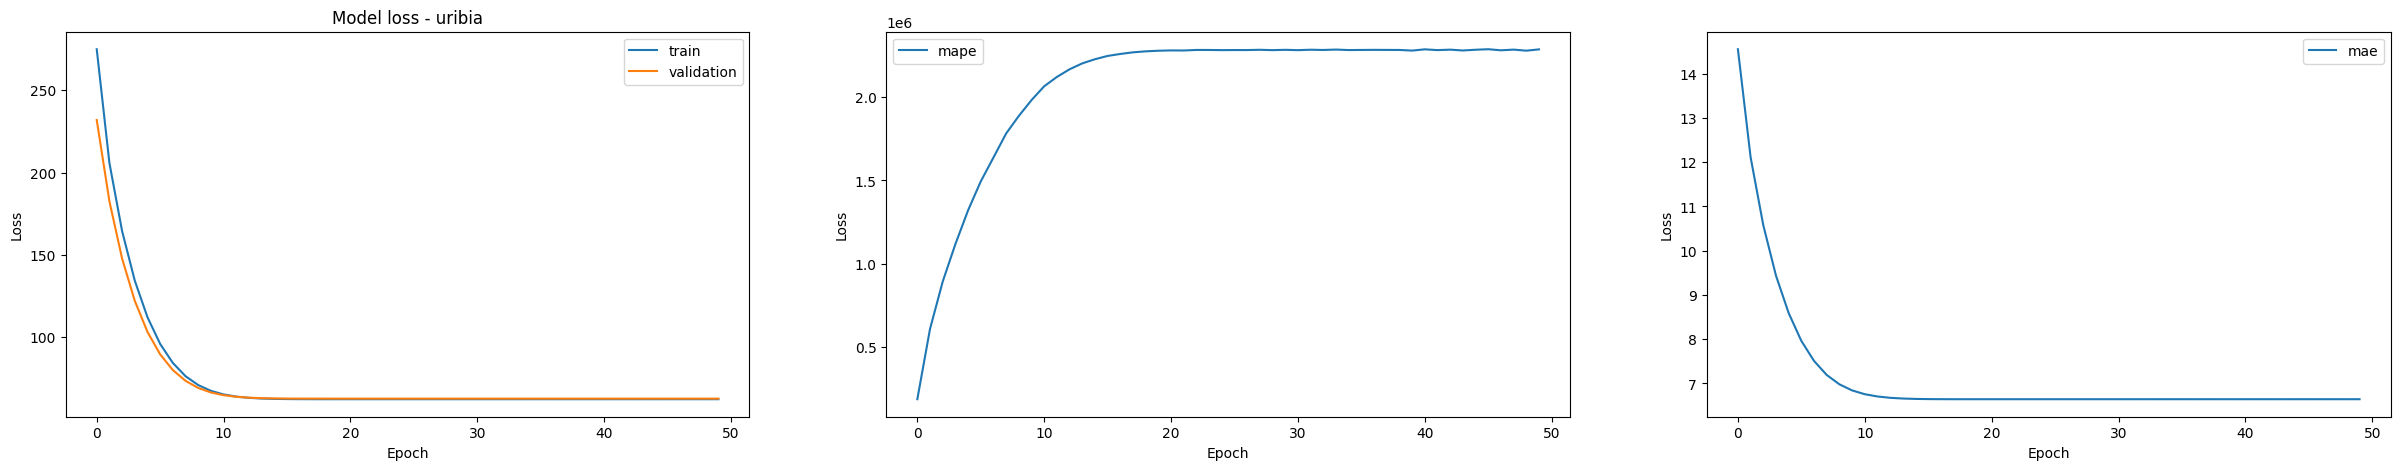

================================================ riohacha
Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 278.8633 - mae: 14.6837 - mape: 64052.2500 - mse: 278.8633 - val_loss: 219.1376 - val_mae: 12.5298 - val_mape: 271564.3438 - val_mse: 219.1376
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 203.6560 - mae: 11.9414 - mape: 417013.1250 - mse: 203.6560 - val_loss: 169.7663 - val_mae: 10.6223 - val_mape: 477169.9688 - val_mse: 169.7663
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 161.0459 - mae: 10.2674 - mape: 640032.1875 - mse: 161.0459 - val_loss: 136.9322 - val_mae: 9.3498 - val_mape: 642889.1875 - val_mse: 136.9322
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 130.5324 - mae: 9.1132 - mape: 930659.1875 - mse: 130.5324 - val_loss: 113.2957 - val_mae: 8.4484 - val_mape: 786864.5000 - val_mse: 113.2957
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 108.2682 - mae: 8.2547 - mape: 881311.1875 - mse: 108.2682 - val_

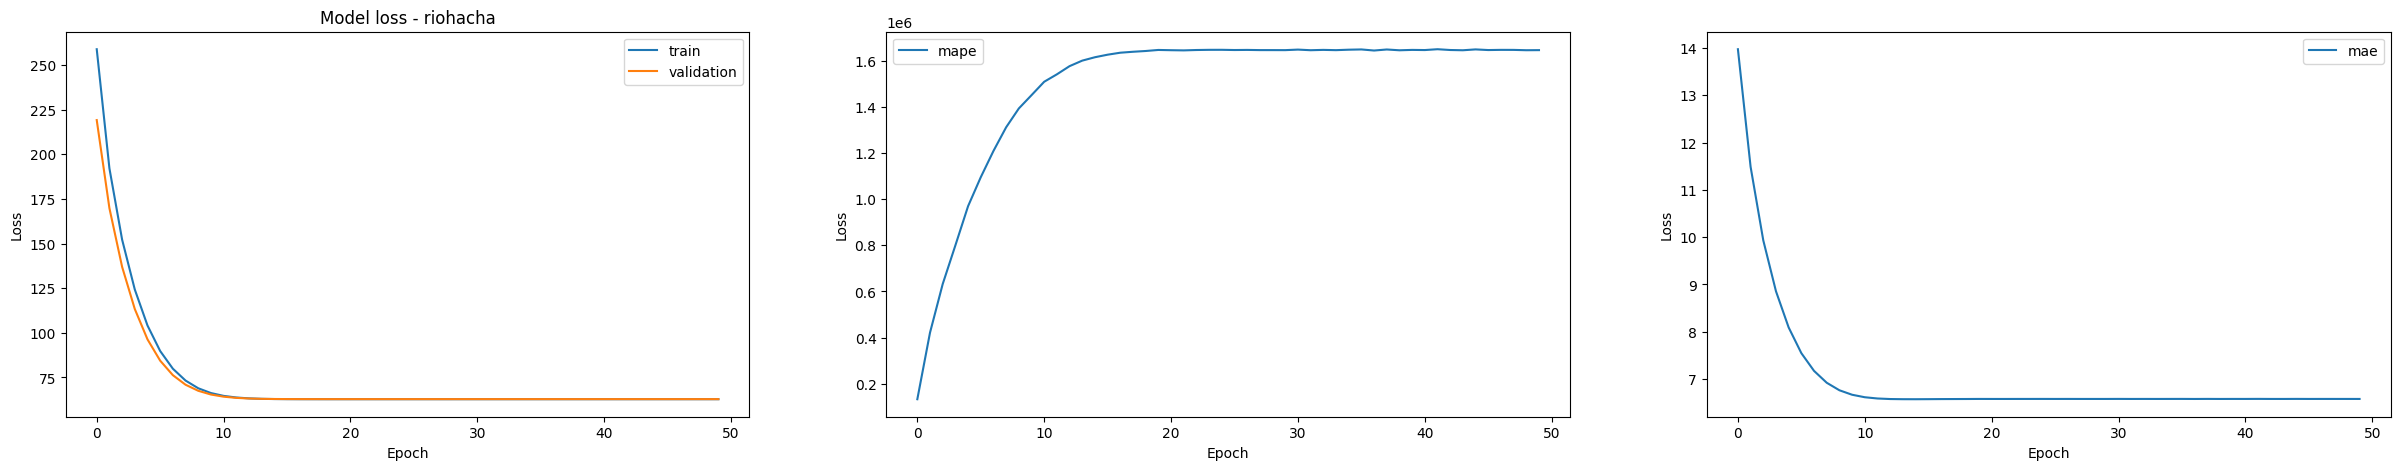

================================================ hatonuevo
Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 97.4070 - mae: 8.7102 - mape: 245667.9531 - mse: 97.4070 - val_loss: 65.8071 - val_mae: 6.7701 - val_mape: 1620743.1250 - val_mse: 65.8071
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 58.8985 - mae: 6.3076 - mape: 1306245.8750 - mse: 58.8985 - val_loss: 43.8727 - val_mae: 5.3236 - val_mape: 2798071.0000 - val_mse: 43.8727
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 40.3770 - mae: 5.0735 - mape: 2399584.5000 - mse: 40.3770 - val_loss: 32.4668 - val_mae: 4.5301 - val_mape: 3658564.5000 - val_mse: 32.4668
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 30.6477 - mae: 4.3893 - mape: 2866773.7500 - mse: 30.6477 - val_loss: 26.4775 - val_mae: 4.0968 - val_mape: 4304498.5000 - val_mse: 26.4775
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 25.3603 - mae: 4.0092 - mape: 3877798.7500 - mse: 25.3603 - val_loss: 23.5313

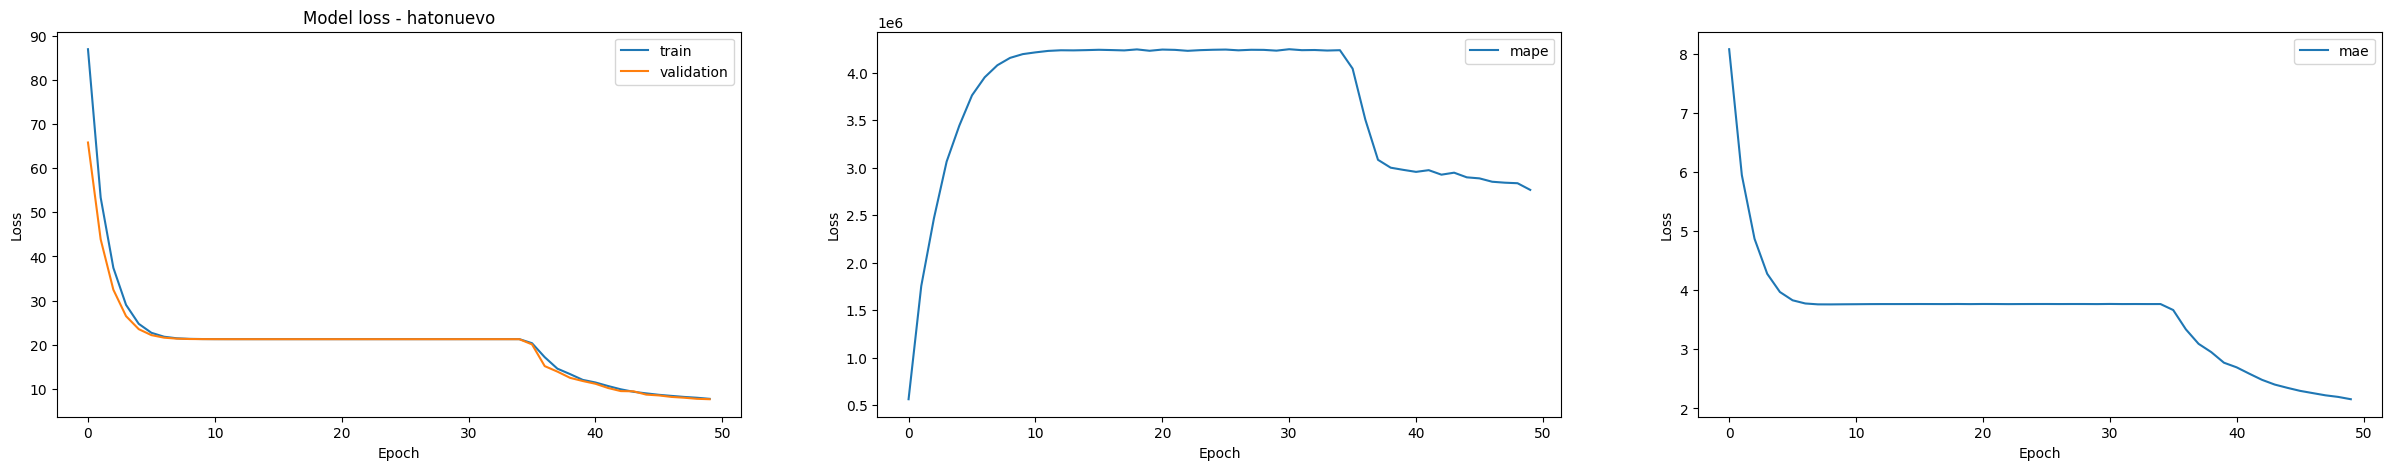

================================================ el_molino
Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 213.7495 - mae: 12.6203 - mape: 212498.3750 - mse: 213.7495 - val_loss: 159.3520 - val_mae: 10.4385 - val_mape: 1158612.3750 - val_mse: 159.3520
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 146.0110 - mae: 9.8411 - mape: 1359972.3750 - mse: 146.0110 - val_loss: 121.3577 - val_mae: 8.8884 - val_mape: 1920172.8750 - val_mse: 121.3577
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 112.4893 - mae: 8.4926 - mape: 1810776.7500 - mse: 112.4893 - val_loss: 97.0960 - val_mae: 7.9369 - val_mape: 2526919.5000 - val_mse: 97.0960
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 90.6148 - mae: 7.6385 - mape: 2202356.7500 - mse: 90.6148 - val_loss: 80.7892 - val_mae: 7.3175 - val_mape: 3039153.0000 - val_mse: 80.7892
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 77.2498 - mae: 7.1756 - mape: 2605841.0000 - mse: 77.2498 - val_l

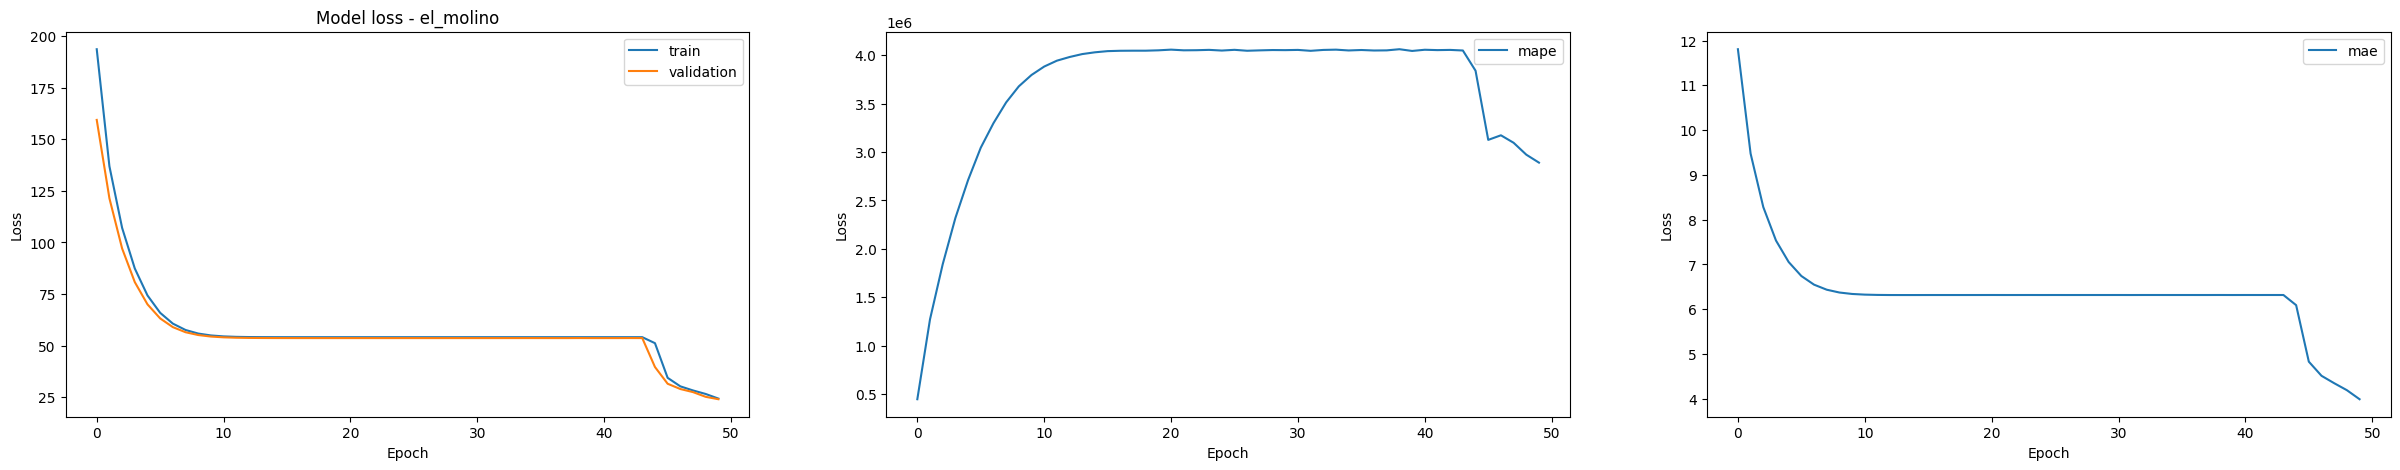

================================================ mingueo
Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 86.1985 - mae: 7.1937 - mape: 571665.7500 - mse: 86.1985 - val_loss: 60.7502 - val_mae: 5.5270 - val_mape: 1732265.3750 - val_mse: 60.7502
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 54.6508 - mae: 5.1968 - mape: 2453796.0000 - mse: 54.6508 - val_loss: 46.2352 - val_mae: 4.8263 - val_mape: 2700988.0000 - val_mse: 46.2352
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 42.7421 - mae: 4.6806 - mape: 3229719.2500 - mse: 42.7421 - val_loss: 39.8324 - val_mae: 4.6684 - val_mape: 3357400.2500 - val_mse: 39.8324
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 37.8534 - mae: 4.6070 - mape: 3875011.7500 - mse: 37.8534 - val_loss: 37.1083 - val_mae: 4.6804 - val_mape: 3794511.5000 - val_mse: 37.1083
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 35.8678 - mae: 4.6528 - mape: 5116044.5000 - mse: 35.8678 - val_loss: 36.0500 -

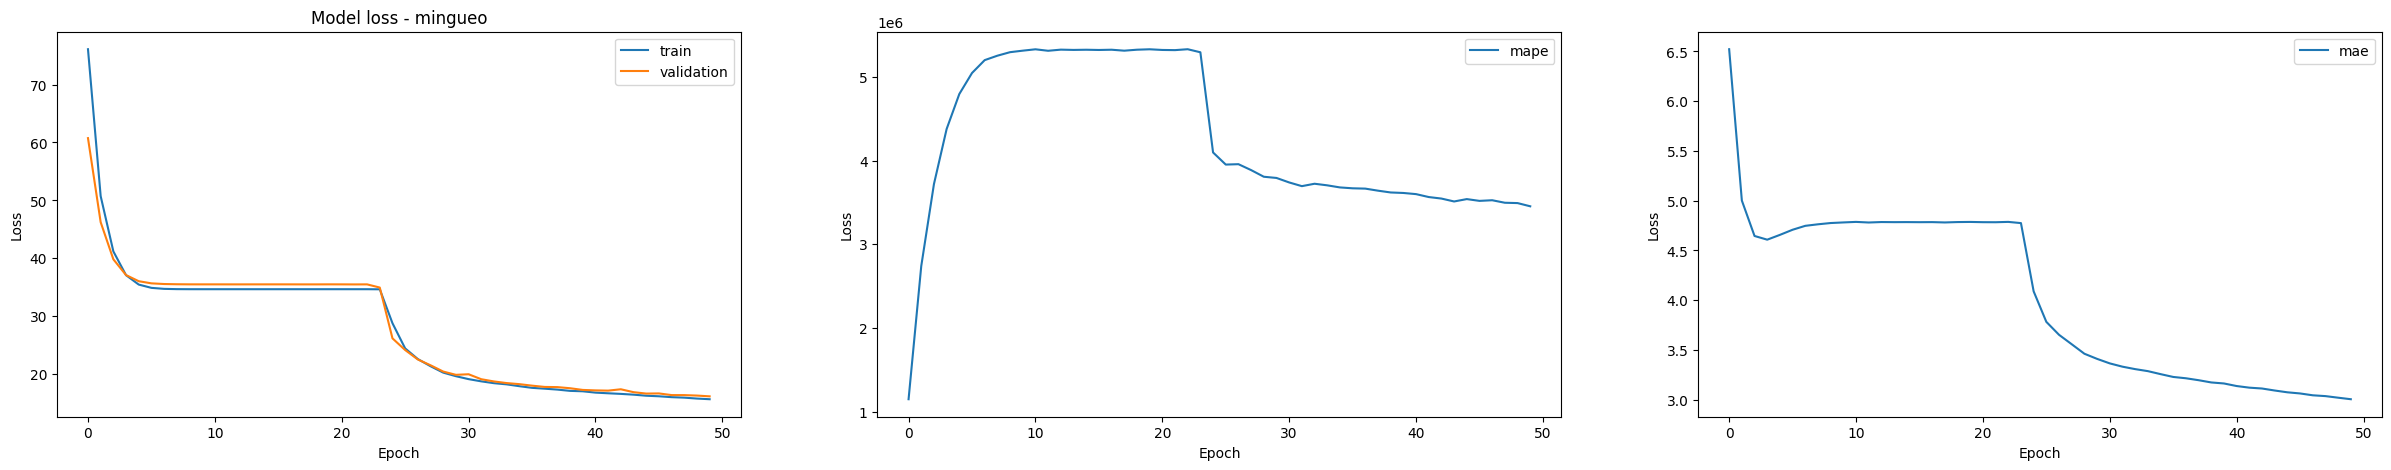

================================================ barrancas
Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 159.9715 - mae: 11.4360 - mape: 207094.2344 - mse: 159.9715 - val_loss: 115.1344 - val_mae: 9.3675 - val_mape: 945156.4375 - val_mse: 115.1344
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 104.9127 - mae: 8.8545 - mape: 905921.3750 - mse: 104.9127 - val_loss: 81.7670 - val_mae: 7.6959 - val_mape: 1595765.5000 - val_mse: 81.7670
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 74.5606 - mae: 7.2976 - mape: 1572287.1250 - mse: 74.5606 - val_loss: 61.1084 - val_mae: 6.5977 - val_mape: 2108184.2500 - val_mse: 61.1084
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 56.8694 - mae: 6.3438 - mape: 2165121.0000 - mse: 56.8694 - val_loss: 47.8218 - val_mae: 5.8409 - val_mape: 2531597.0000 - val_mse: 47.8218
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 45.1989 - mae: 5.6682 - mape: 2505969.5000 - mse: 45.1989 - val_loss: 39

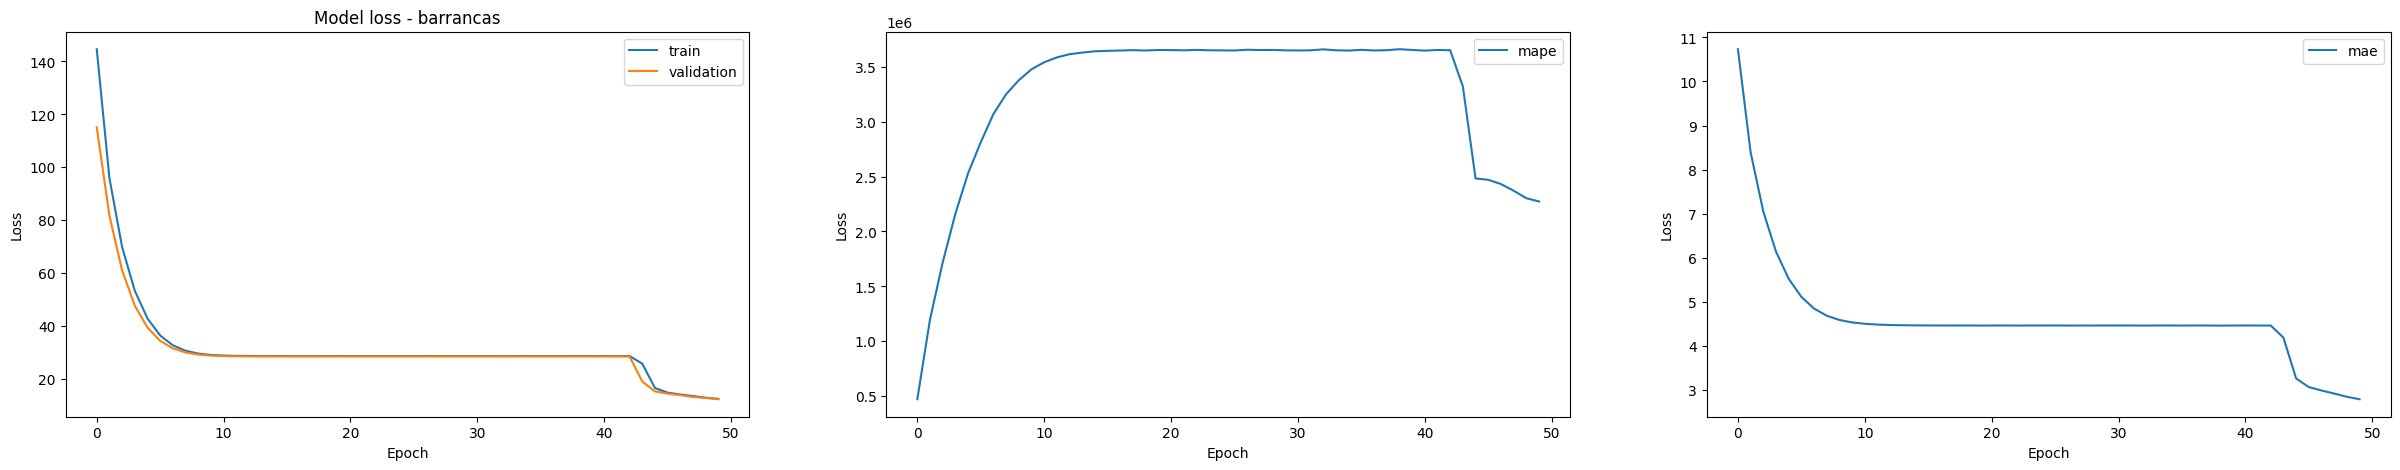

================================================ fonseca
Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 206.4519 - mae: 12.8658 - mape: 91578.4219 - mse: 206.4519 - val_loss: 158.8974 - val_mae: 10.9419 - val_mape: 400396.2812 - val_mse: 158.8974
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 145.8839 - mae: 10.3700 - mape: 376658.7188 - mse: 145.8839 - val_loss: 118.1307 - val_mae: 9.1956 - val_mape: 723215.9375 - val_mse: 118.1307
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 110.3518 - mae: 8.8320 - mape: 609820.8750 - mse: 110.3518 - val_loss: 91.5817 - val_mae: 8.0224 - val_mape: 981628.0625 - val_mse: 91.5817
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 85.4868 - mae: 7.7062 - mape: 910721.7500 - mse: 85.4868 - val_loss: 73.2419 - val_mae: 7.1796 - val_mape: 1203080.2500 - val_mse: 73.2419
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 68.5554 - mae: 6.9060 - mape: 1139297.1250 - mse: 68.5554 - val_loss: 60.

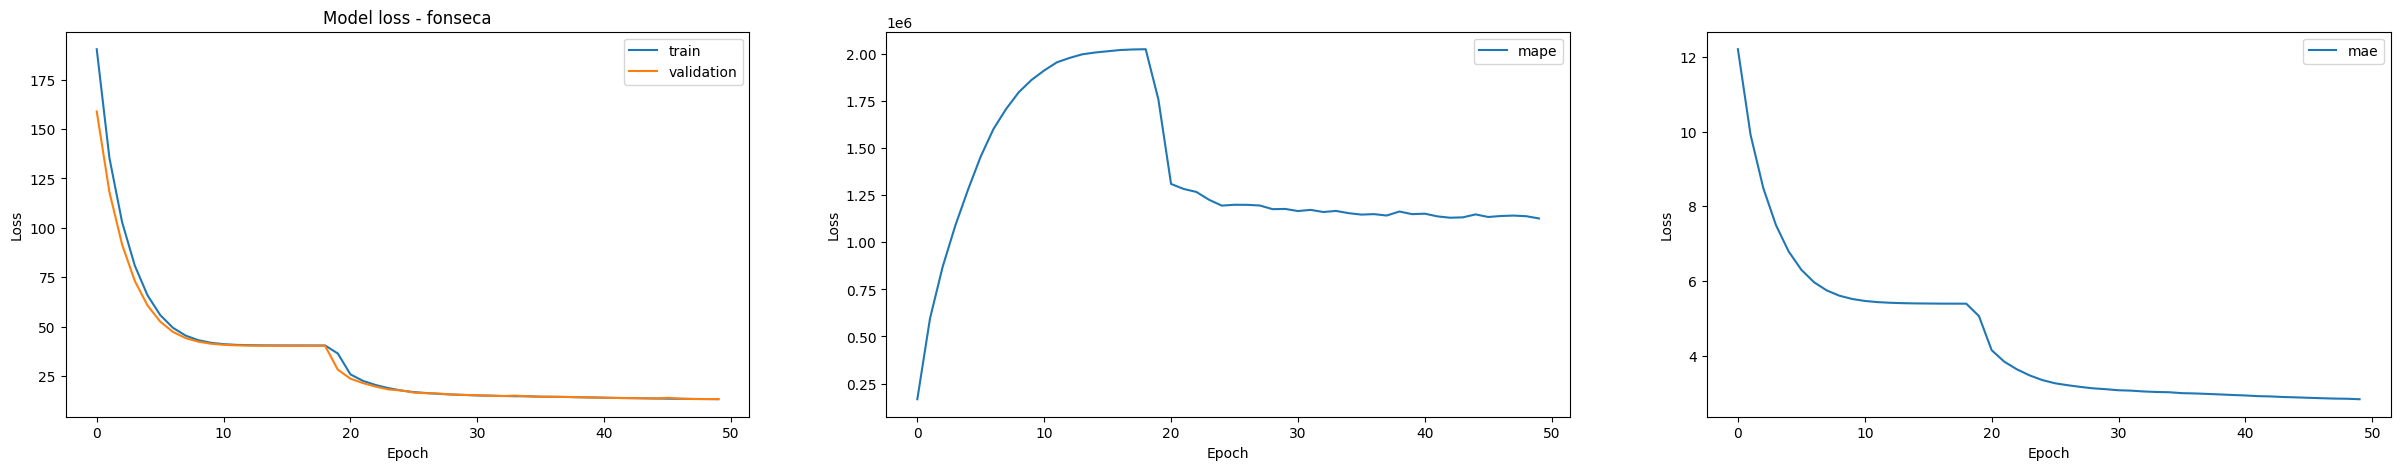

================================================ manaure
Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 325.8849 - mae: 16.3908 - mape: 56447.1250 - mse: 325.8849 - val_loss: 251.6644 - val_mae: 13.9682 - val_mape: 212216.7969 - val_mse: 251.6644
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 235.8087 - mae: 13.4163 - mape: 368661.8750 - mse: 235.8087 - val_loss: 197.5728 - val_mae: 12.0504 - val_mape: 361956.1250 - val_mse: 197.5728
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 186.2489 - mae: 11.6412 - mape: 579926.8750 - mse: 186.2489 - val_loss: 159.0264 - val_mae: 10.6141 - val_mape: 487824.1562 - val_mse: 159.0264
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 150.1768 - mae: 10.2840 - mape: 834908.5000 - mse: 150.1768 - val_loss: 130.0572 - val_mae: 9.4850 - val_mape: 599418.5000 - val_mse: 130.0572
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 122.2275 - mae: 9.1664 - mape: 545576.0625 - mse: 122.2275 - val

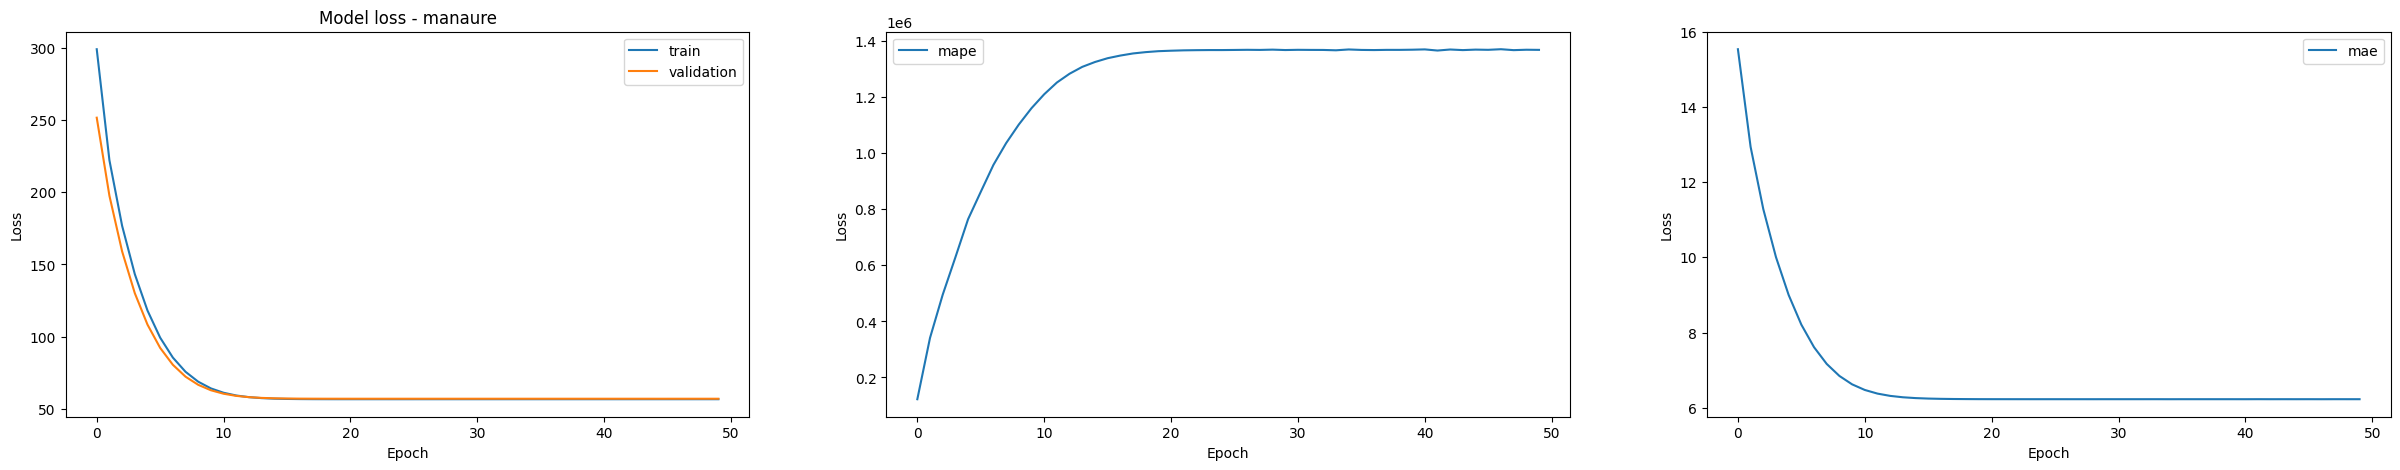

================================================ maicao
Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 248.3070 - mae: 14.2417 - mape: 103780.4375 - mse: 248.3070 - val_loss: 187.7928 - val_mae: 11.9822 - val_mape: 335697.1875 - val_mse: 187.7928
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 173.0912 - mae: 11.4024 - mape: 652959.3750 - mse: 173.0912 - val_loss: 141.7118 - val_mae: 10.1149 - val_mape: 567053.0000 - val_mse: 141.7118
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 132.2709 - mae: 9.7193 - mape: 952663.8125 - mse: 132.2709 - val_loss: 110.9558 - val_mae: 8.8024 - val_mape: 772582.6875 - val_mse: 110.9558
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 103.3544 - mae: 8.4797 - mape: 1217576.2500 - mse: 103.3544 - val_loss: 89.0981 - val_mae: 7.8292 - val_mape: 950622.7500 - val_mse: 89.0981
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 84.8016 - mae: 7.6406 - mape: 1372542.2500 - mse: 84.8016 - val_loss

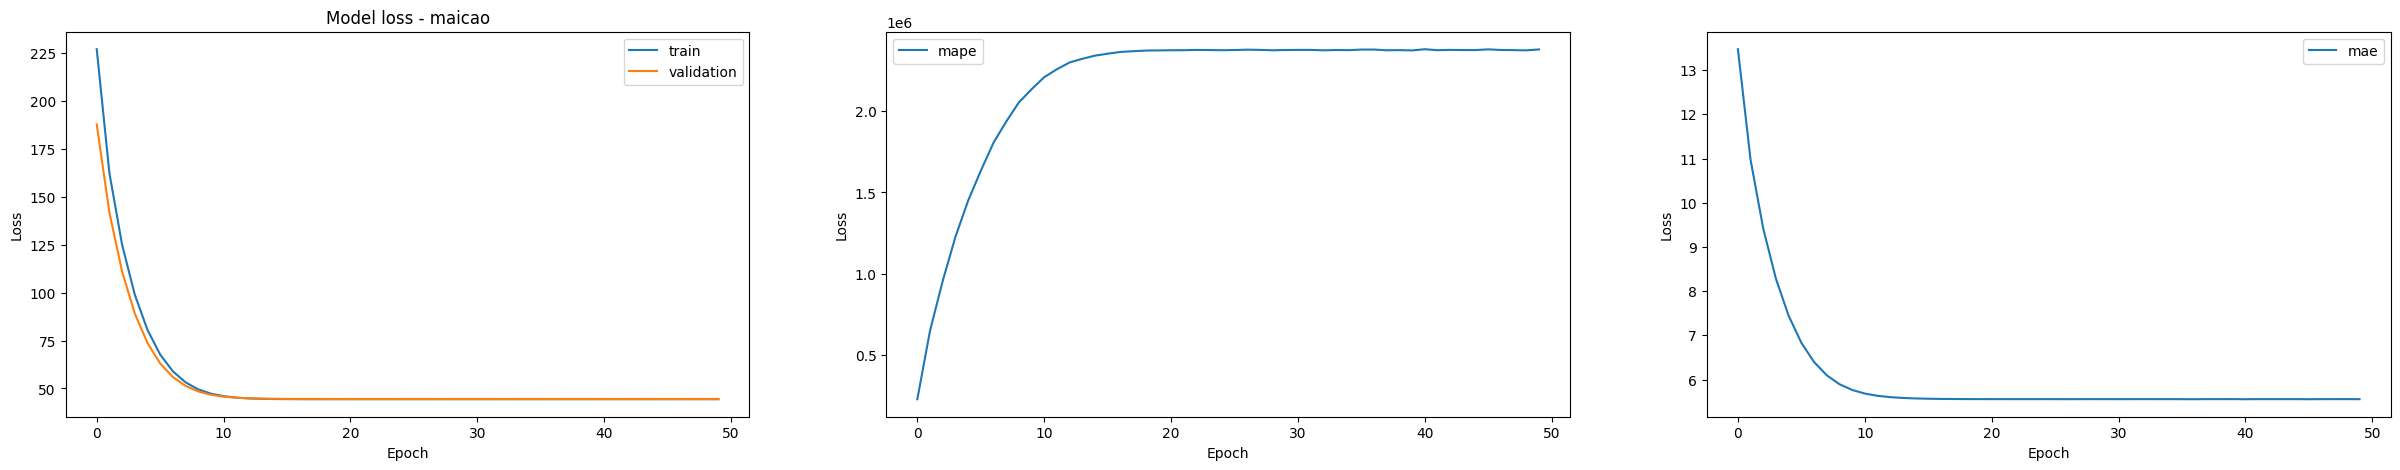

================================================ san_juan_del_cesar
Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 232.5839 - mae: 13.6014 - mape: 130226.3906 - mse: 232.5839 - val_loss: 178.0914 - val_mae: 11.5415 - val_mape: 805344.0625 - val_mse: 178.0914
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 163.6208 - mae: 10.9371 - mape: 797533.8750 - mse: 163.6208 - val_loss: 135.2551 - val_mae: 9.8422 - val_mape: 1392731.7500 - val_mse: 135.2551
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 126.1254 - mae: 9.4396 - mape: 1247686.0000 - mse: 126.1254 - val_loss: 106.4232 - val_mae: 8.6900 - val_mape: 1873566.3750 - val_mse: 106.4232
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 100.0141 - mae: 8.4002 - mape: 1783309.1250 - mse: 100.0141 - val_loss: 86.0720 - val_mae: 7.8463 - val_mape: 2288833.7500 - val_mse: 86.0720
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 81.5813 - mae: 7.6194 - mape: 2046146.6250 - mse: 81.

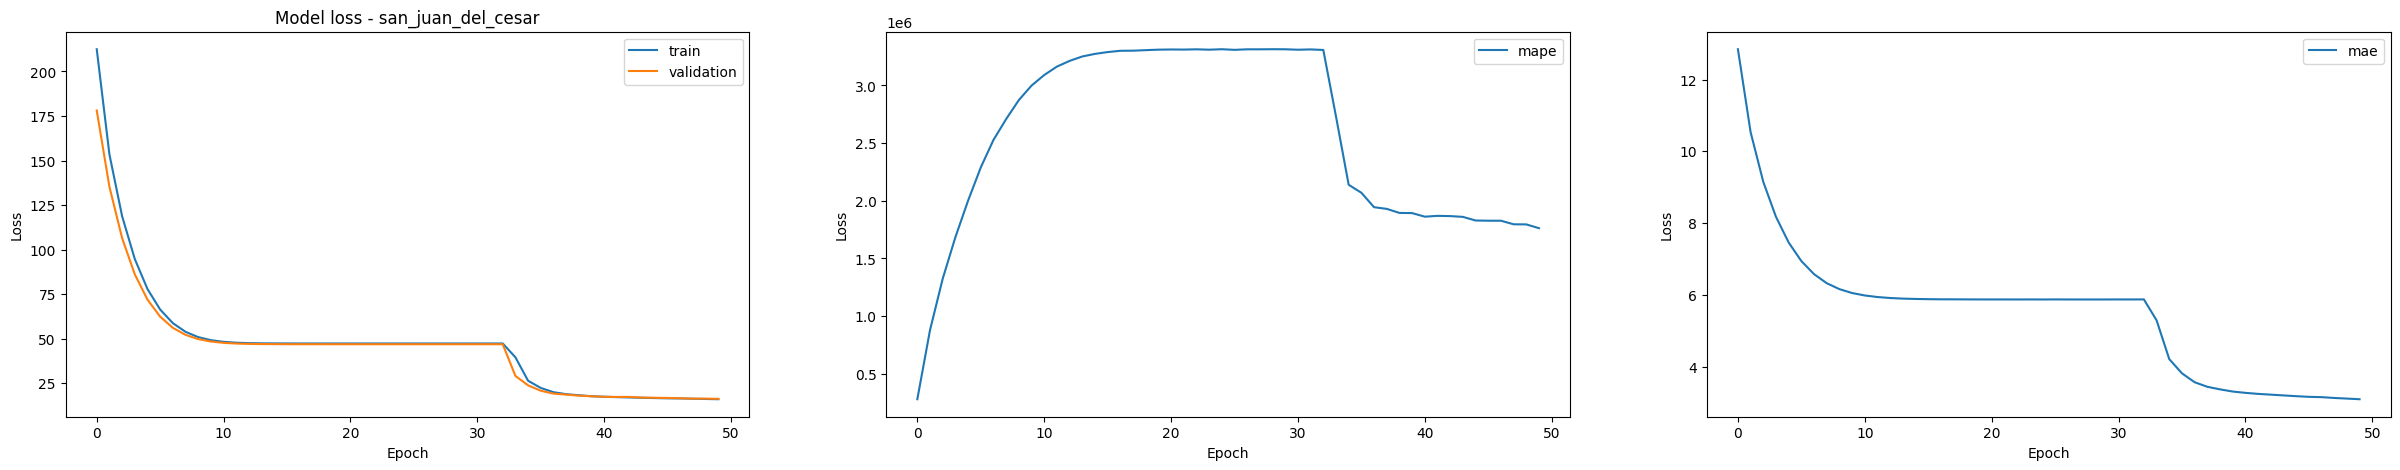

================================================ albania
Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 96.3967 - mae: 8.5728 - mape: 224570.6250 - mse: 96.3967 - val_loss: 63.8716 - val_mae: 6.5573 - val_mape: 1340386.8750 - val_mse: 63.8716
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 57.4493 - mae: 6.1258 - mape: 1528723.6250 - mse: 57.4493 - val_loss: 43.1816 - val_mae: 5.1972 - val_mape: 2260343.2500 - val_mse: 43.1816
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 40.0086 - mae: 4.9858 - mape: 2336514.5000 - mse: 40.0086 - val_loss: 32.3731 - val_mae: 4.5237 - val_mape: 2943595.7500 - val_mse: 32.3731
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 30.5020 - mae: 4.3947 - mape: 2772196.7500 - mse: 30.5020 - val_loss: 26.8105 - val_mae: 4.1827 - val_mape: 3457725.5000 - val_mse: 26.8105
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 25.7927 - mae: 4.1118 - mape: 3325695.2500 - mse: 25.7927 - val_loss: 24.1977 -

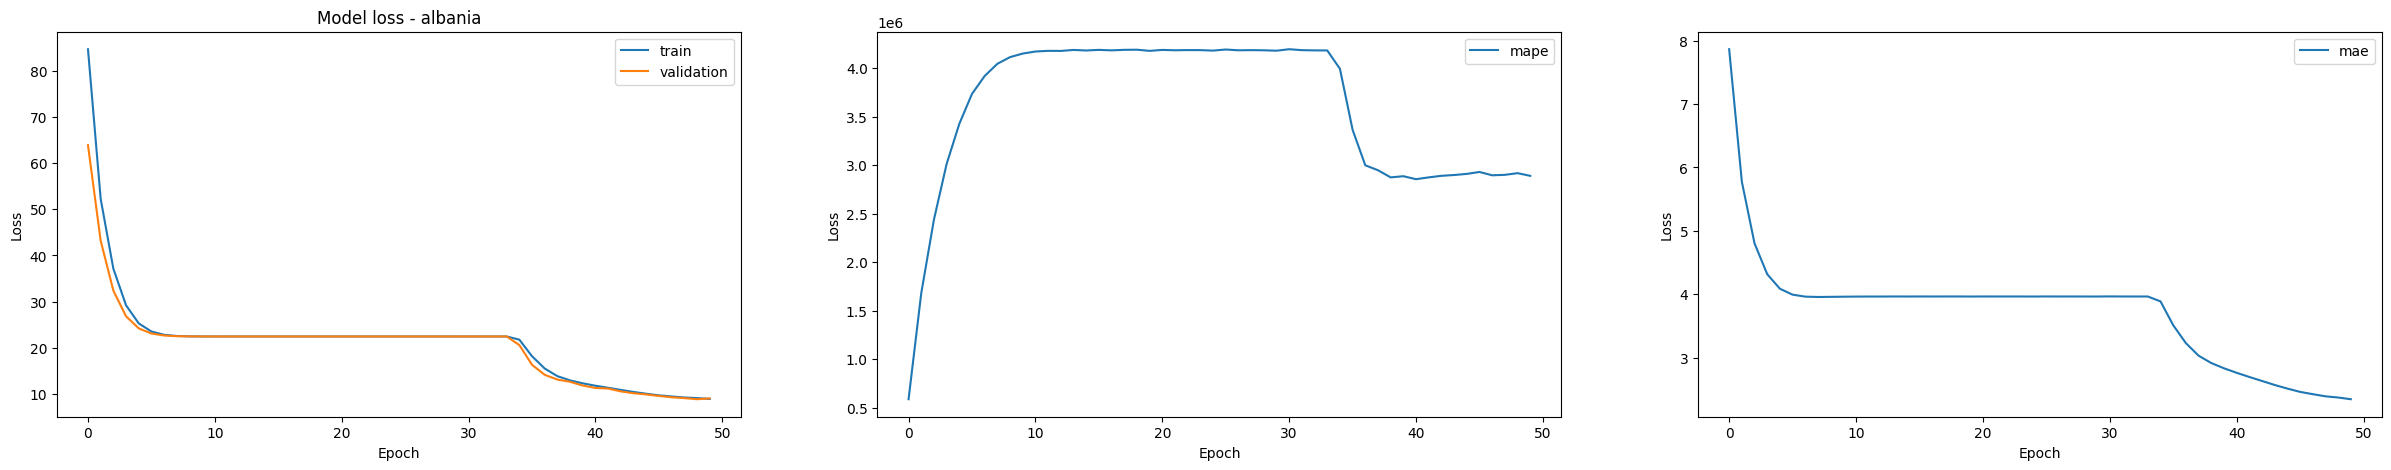

In [11]:
for name in data.keys():

    print("======"*8, name)
    # Get data
    X_train = data[name]['X_train']
    y_train = data[name]['y_train']
    X_valid = data[name]['X_valid']
    y_valid = data[name]['y_valid']
    X_test  = data[name]['X_test']
    y_test  = data[name]['y_test']

    # Create model
    model = LSTM_model(X_train, y_train, X_valid, y_valid, X_test, y_test)
    #model.summary()

    # Compile model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse', 'mape'])

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_valid, y_valid))

    # Plot training & validation loss values
    plt.figure(figsize=(30,5))
    plt.subplot(1, 3, 1)
    plt.title(f"Model loss - {name}")
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.legend(['train', 'validation'])
    plt.subplot(1, 3, 2)
    plt.plot(history.history['mape'])
    plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.legend(['mape'])
    plt.subplot(1, 3, 3)
    plt.plot(history.history['mae'])
    plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.legend(['mae'])
    plt.show()

    # Performance
    """
    forecasting = model.predict(X_test)
    col_names, MSE, RMSE, MAE, R2 = ['Metrics'], ["MSE"], ["RMSE"], ["MAE"], ["R2"]

    for k in range(predictionHorizonMax):

      col_names.append(str(k+1))
      MSE.append(round(mean_squared_error(y_test[:,k], forecasting[:,k]), 3))
      RMSE.append(round(np.sqrt(mean_squared_error(y_test[:,k], forecasting[:,k])), 3))
      MAE.append(round(mean_absolute_error(y_test[:,k], forecasting[:,k]), 3))
      R2.append(round(r2_score(y_test[:,k], forecasting[:,k]), 3))

    data = [MSE, RMSE, MAE, R2]
    print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))
    """

    # save model
    model.save(f'{path}/models/LSTM/{name}_model.keras')

    # save history
    with open(f'{path}/models/LSTM/{name}_history.pkl', 'wb') as f:
        pickle.dump(history.history, f)
